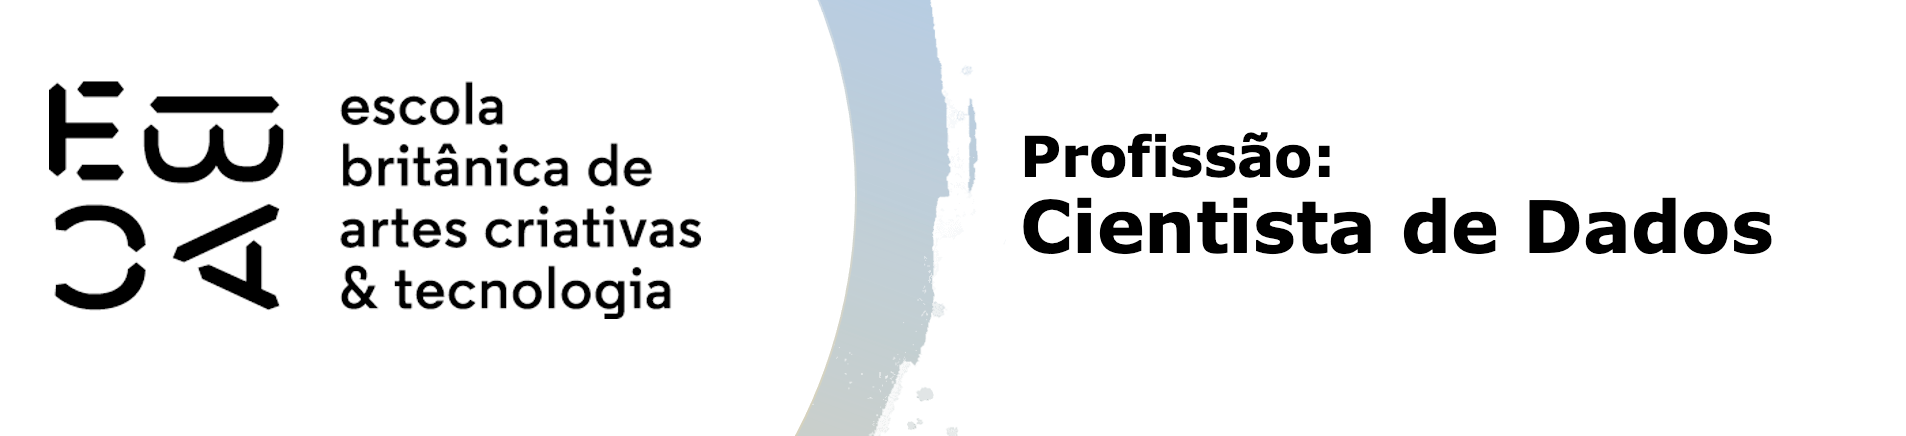

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t

In [2]:
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df_copy = df.copy()
df_copy['renda_log'] = np.log(df_copy['renda'])
df_copy['month'] = df_copy['data_ref'].dt.month
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)
df_copy.drop('index', axis=1, inplace=True)
df_copy.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,7.830183,1
1,2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,8.064696,1
2,2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,7.366628,1
3,2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,9.526695,1
4,2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,7.969385,1


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
print("Treino:")
print(f"Início -> {df_train['data_ref'].min()} \nFim    -> {df_train['data_ref'].max()}")
print()
print("Validação:")
print(f"Início -> {df_valid['data_ref'].min()} \nFim    -> {df_valid['data_ref'].max()}" )

Treino:
Início -> 2015-01-01 00:00:00 
Fim    -> 2015-11-01 00:00:00

Validação:
Início -> 2015-12-01 00:00:00 
Fim    -> 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
print("Treino:")
print(f"Nùm. linhas : {df_train.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas: {df_train.shape[1]:,.0f}".replace(",","."))
print()
print("Validação:")
print(f"Nùm. linhas  : {df_valid.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas : {df_valid.shape[1]:,.0f}".replace(",","."))

Treino:
Nùm. linhas : 550.000
Nùm. colunas: 16

Validação:
Nùm. linhas  : 200.000
Nùm. colunas : 16


In [6]:
# Número de linhas para cada mês em data_ref na base de treino
df_train.groupby("month")['data_ref'].count()

month
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
Name: data_ref, dtype: int64

In [7]:
# Número de linhas para cada mês em data_ref na base de teste
df_valid.groupby("month")['data_ref'].count()

month
1     50000
2     50000
3     50000
12    50000
Name: data_ref, dtype: int64

In [8]:
df_copy.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
renda_log                       float64
month                             int32
dtype: object

In [9]:
ax_index = [
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],
]
ax_index

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0]]

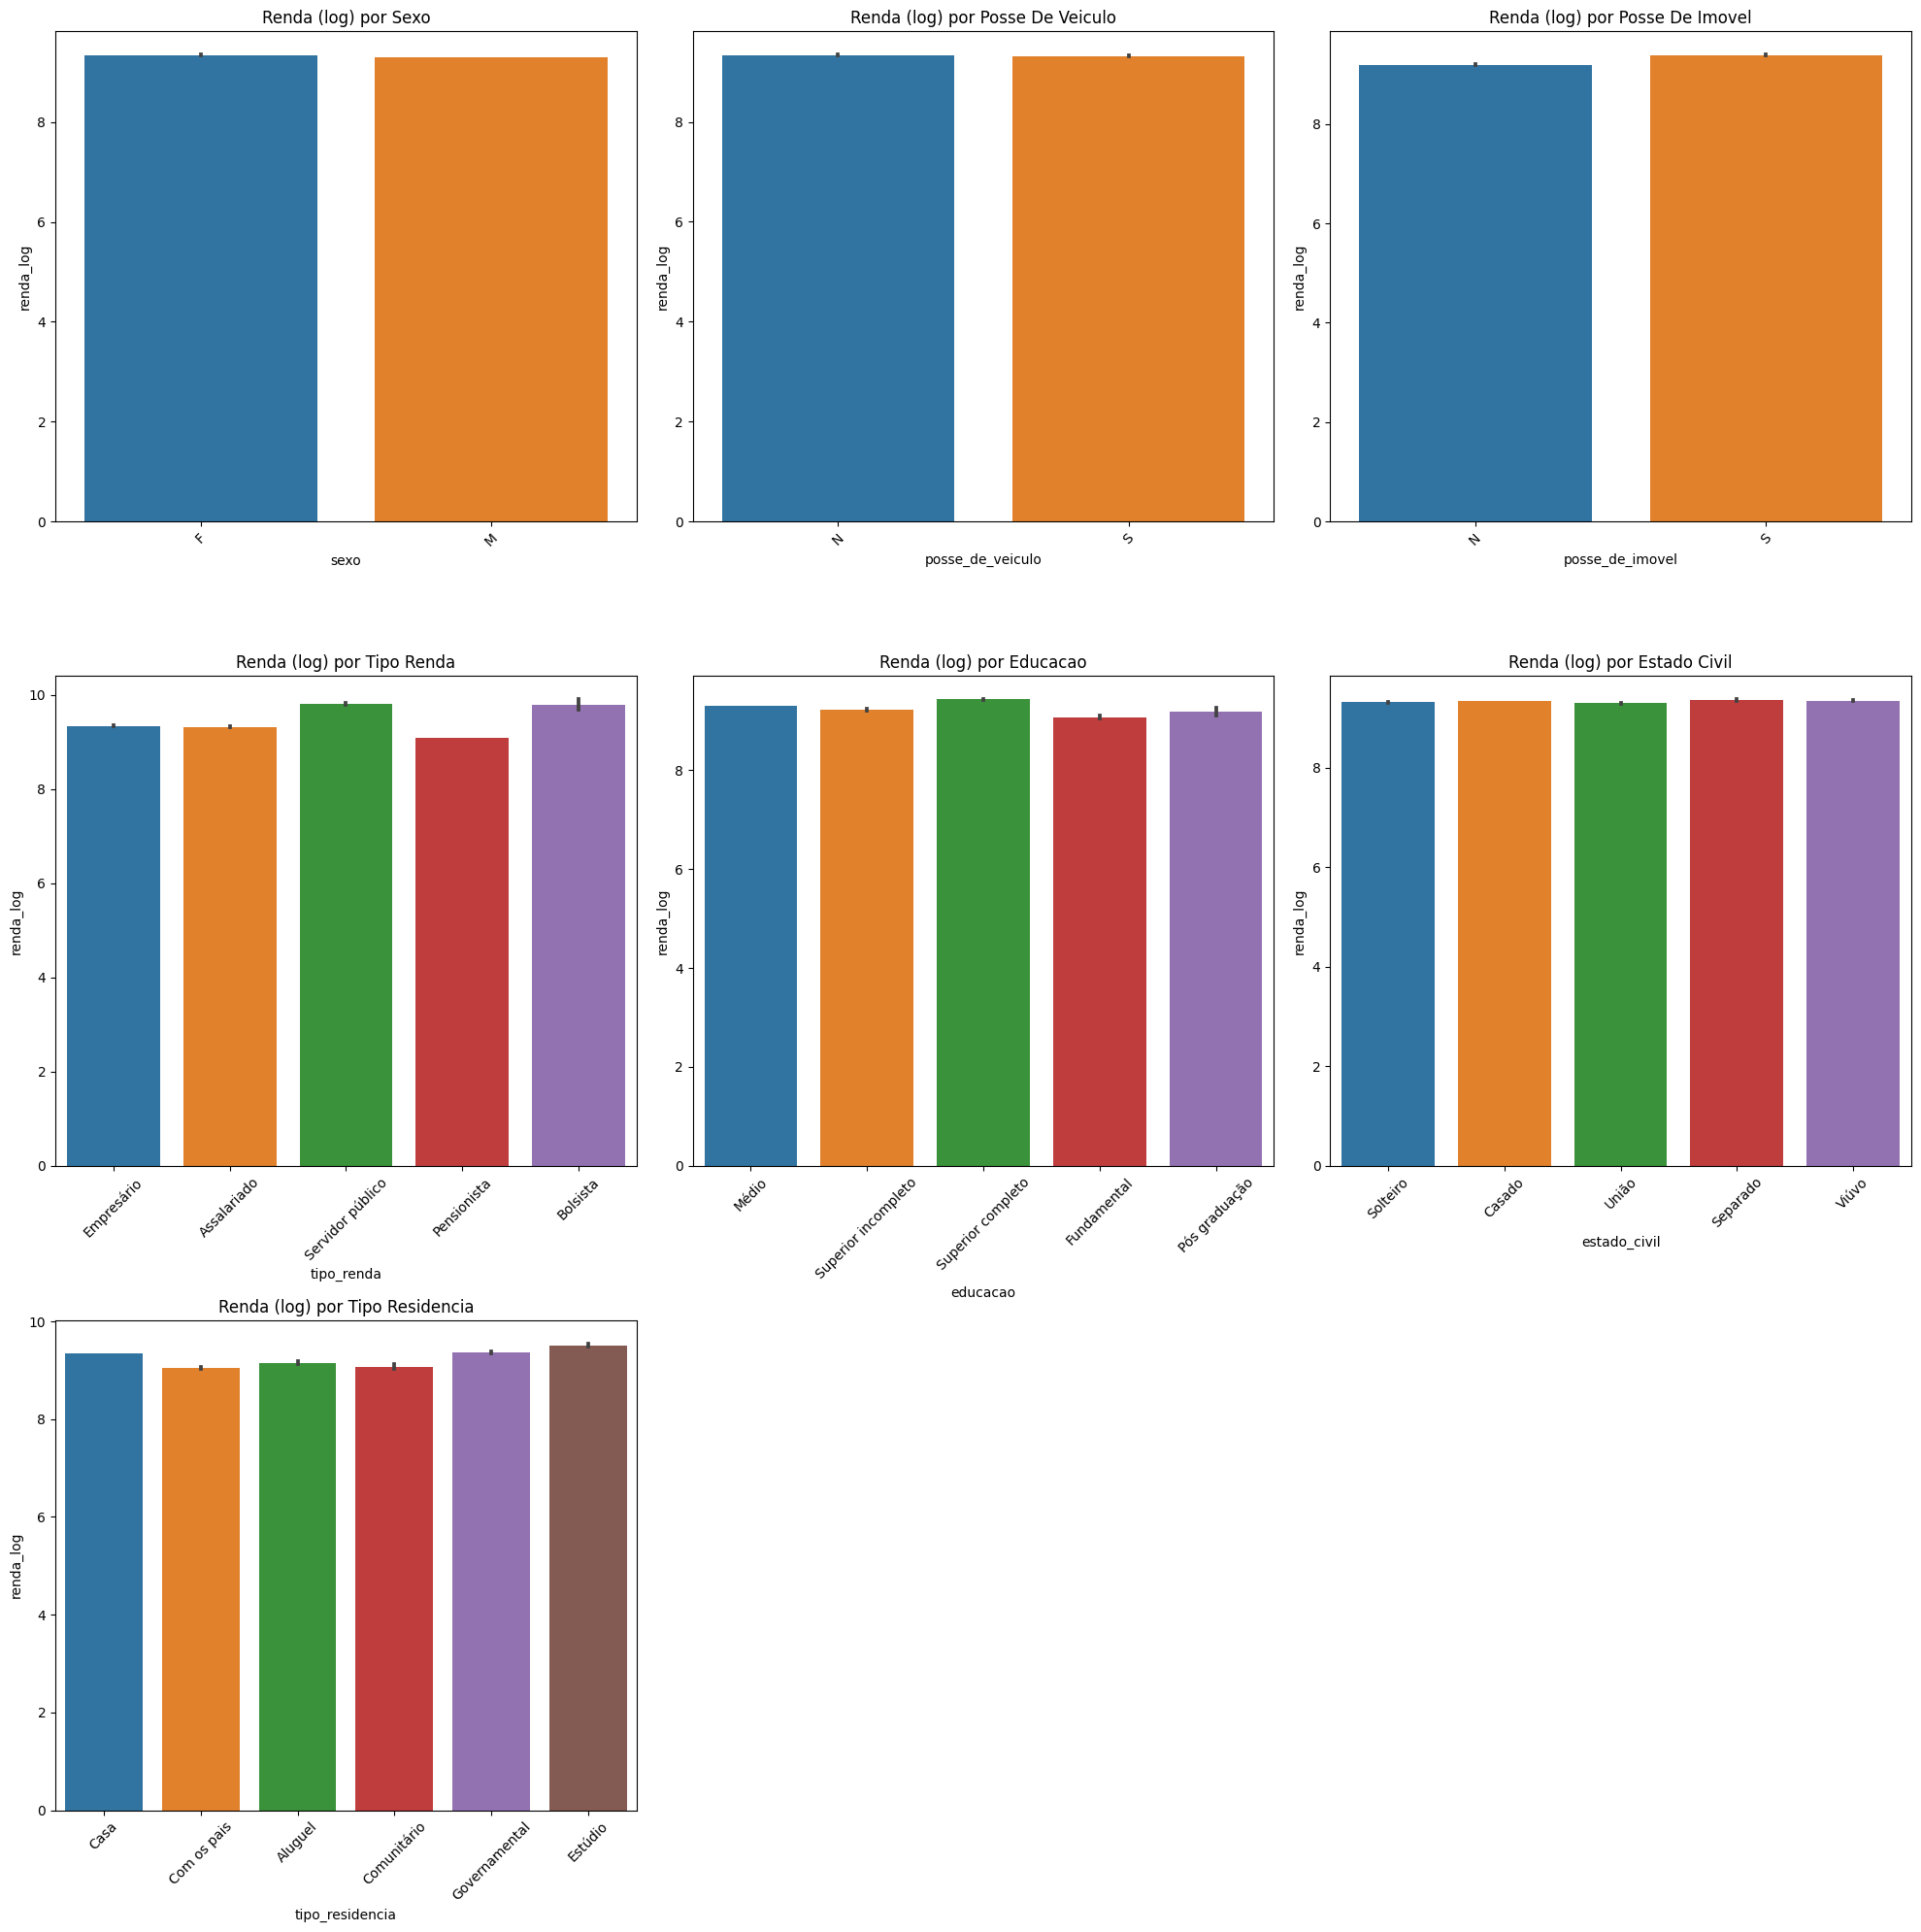

In [10]:
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_train,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

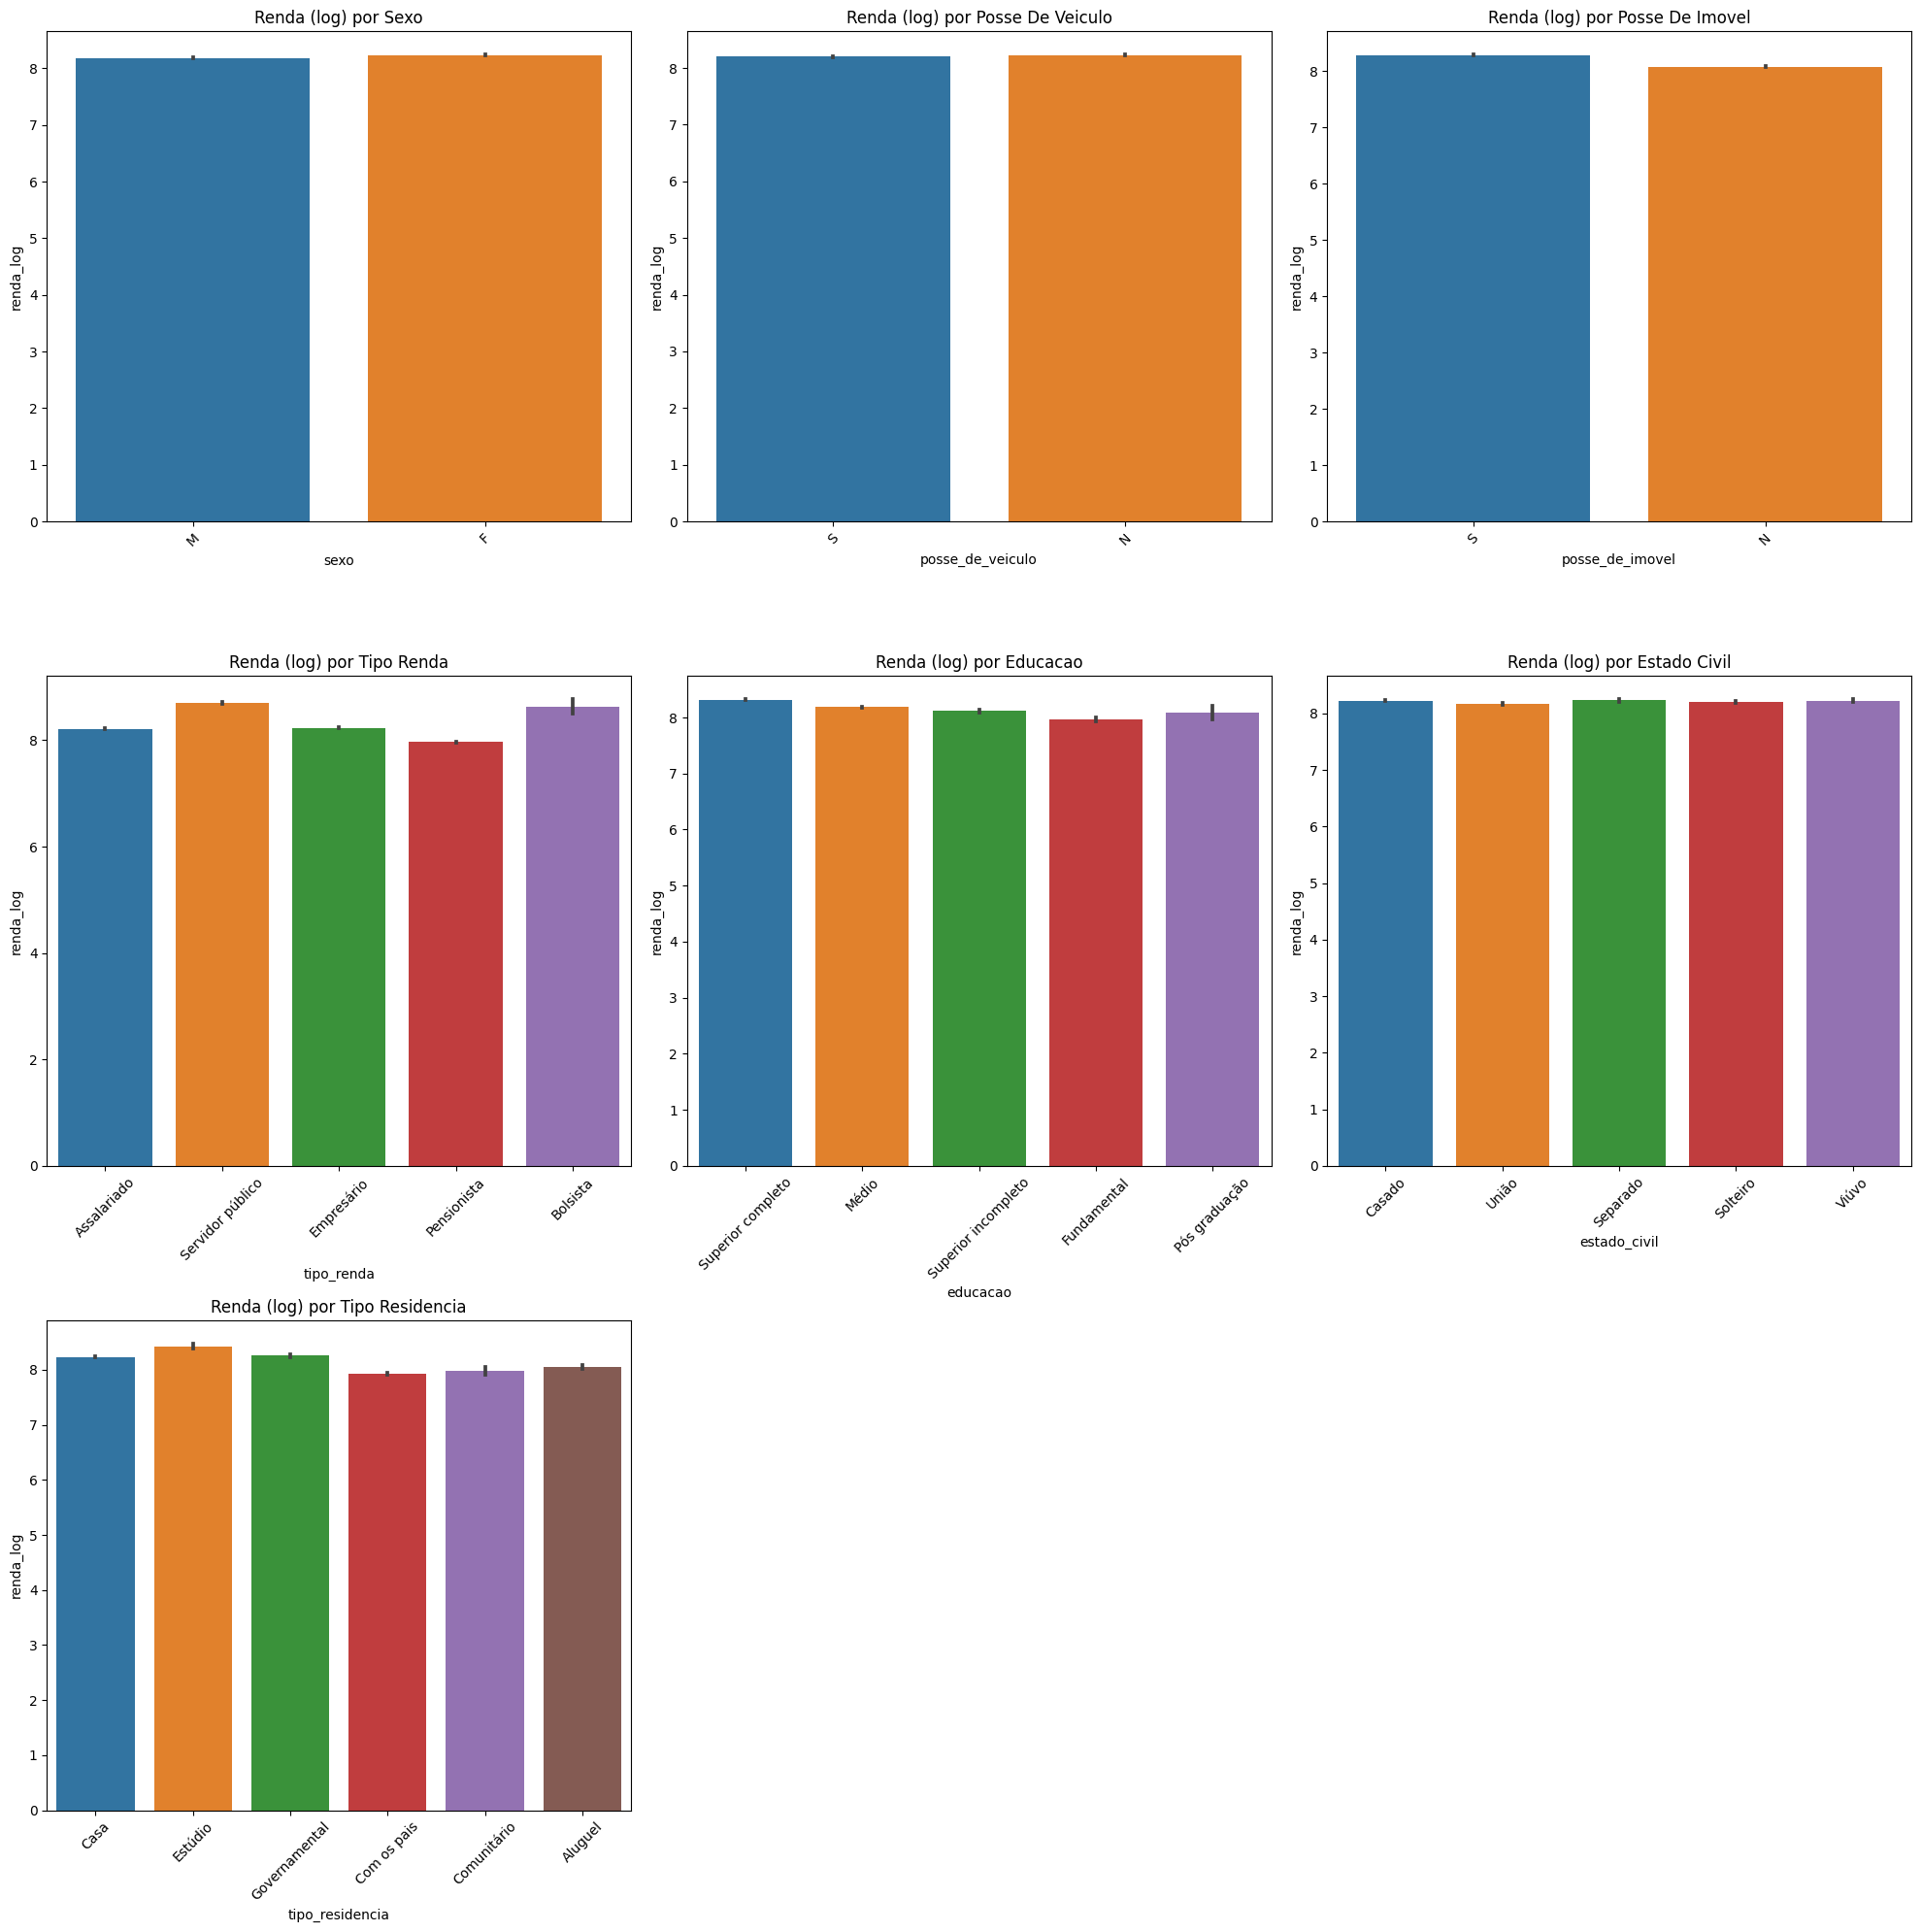

In [11]:
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_valid,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

In [12]:
df_train.select_dtypes(["float64","int32"]).dtypes.index

Index(['tempo_emprego', 'qt_pessoas_residencia', 'renda', 'renda_log',
       'month'],
      dtype='object')

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

<function matplotlib.pyplot.show(close=None, block=None)>

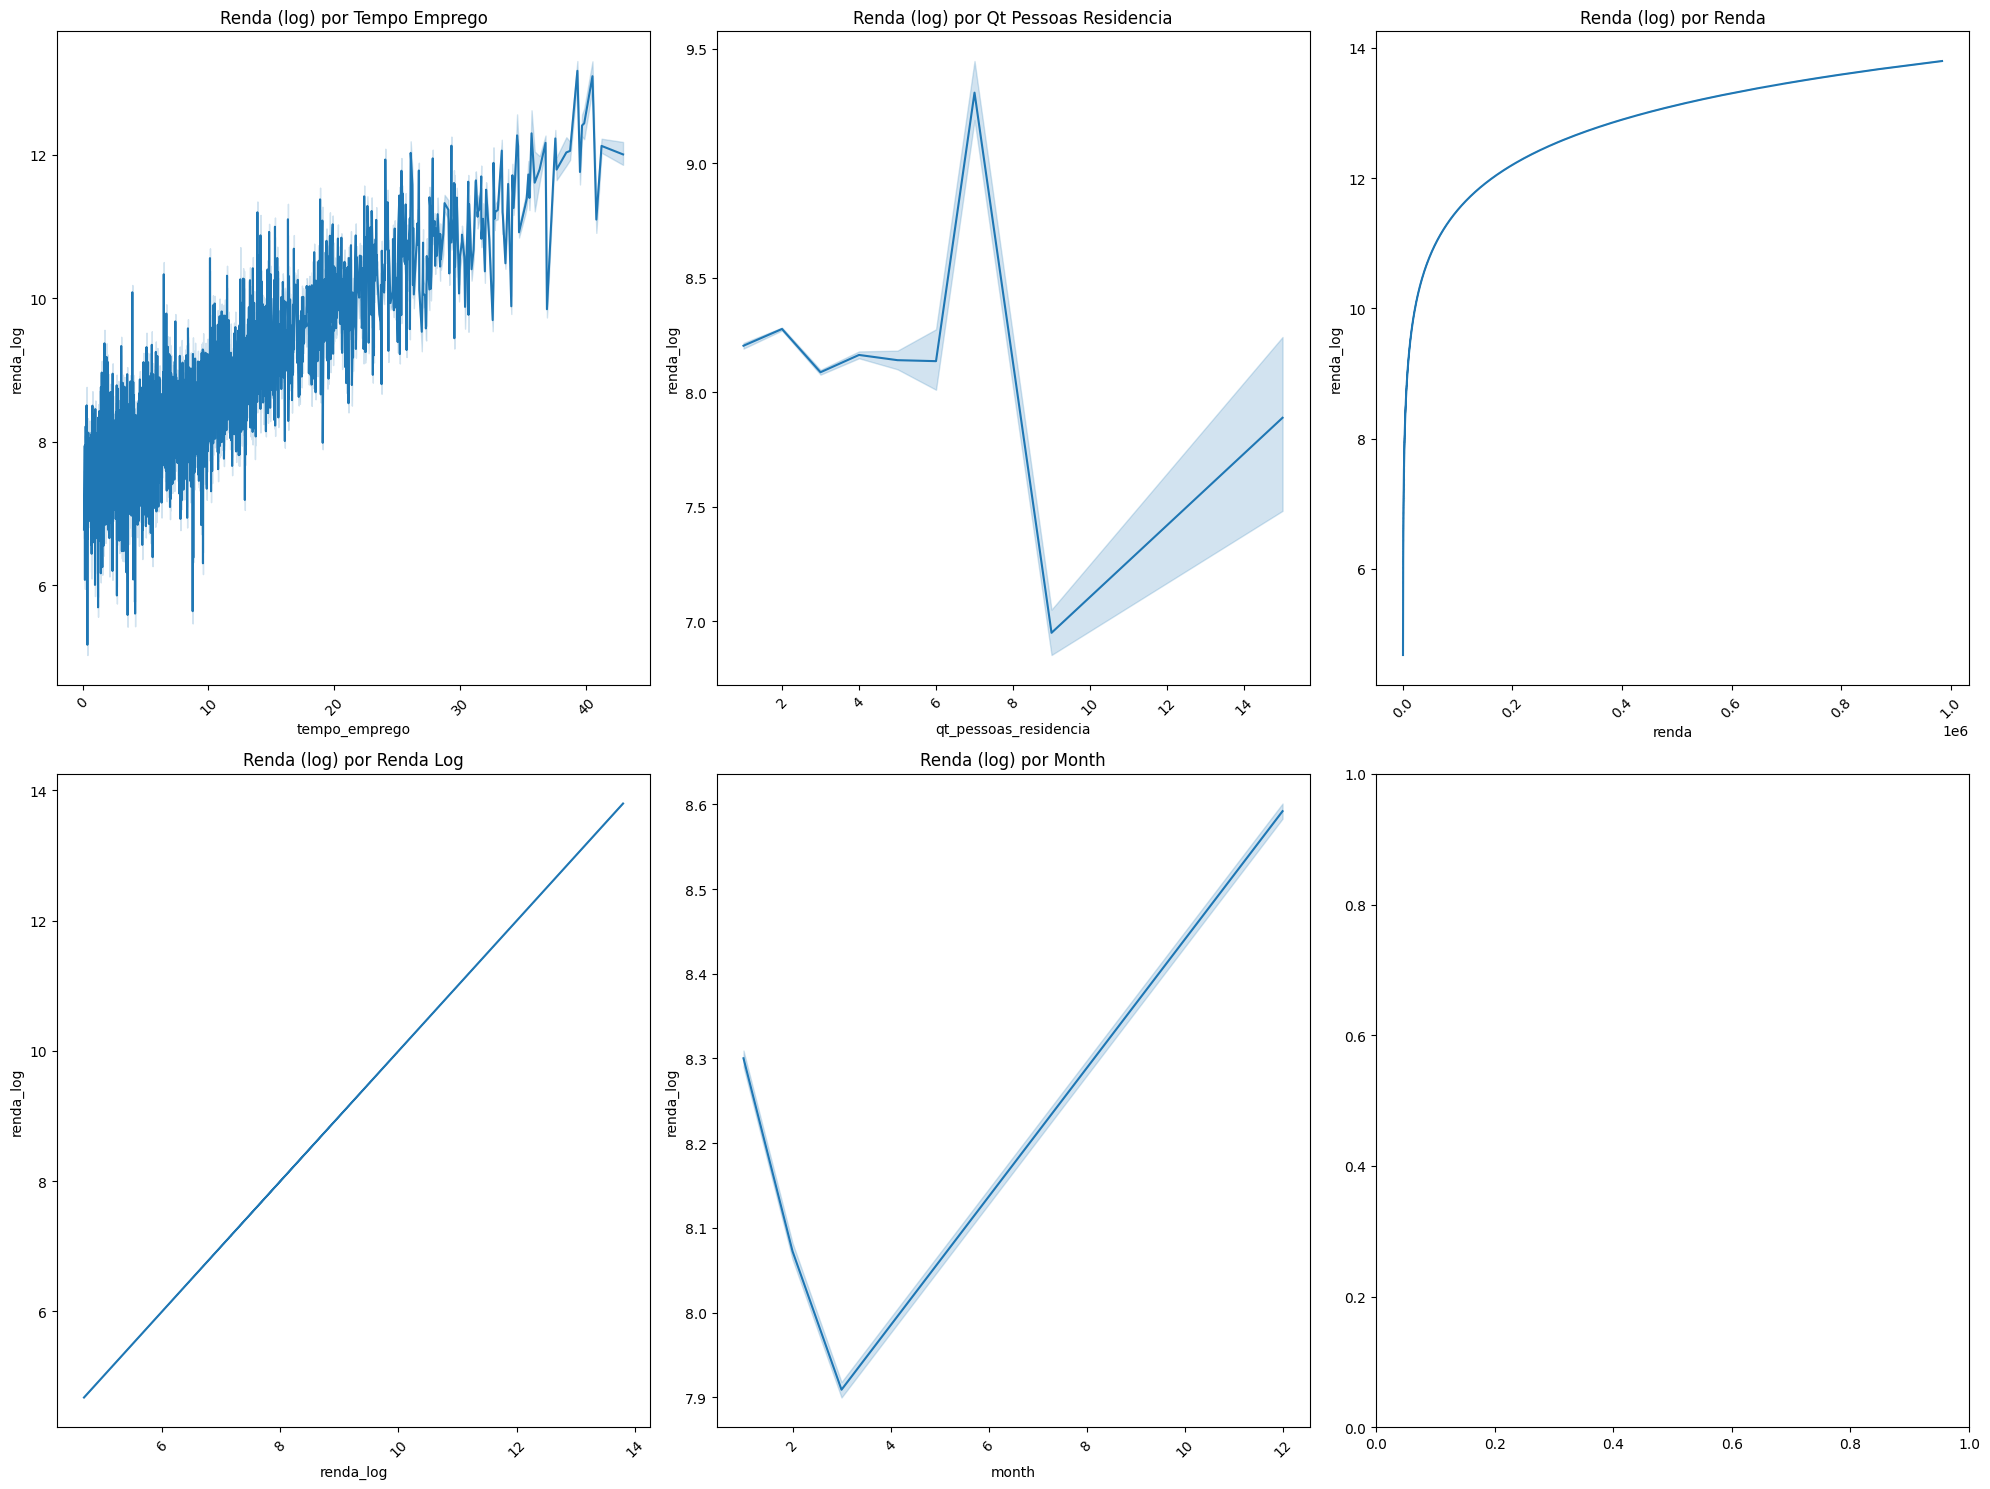

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_valid,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
# ax[2,1].set_axis_off()
# ax[2,2].set_axis_off()
plt.show

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

<function matplotlib.pyplot.show(close=None, block=None)>

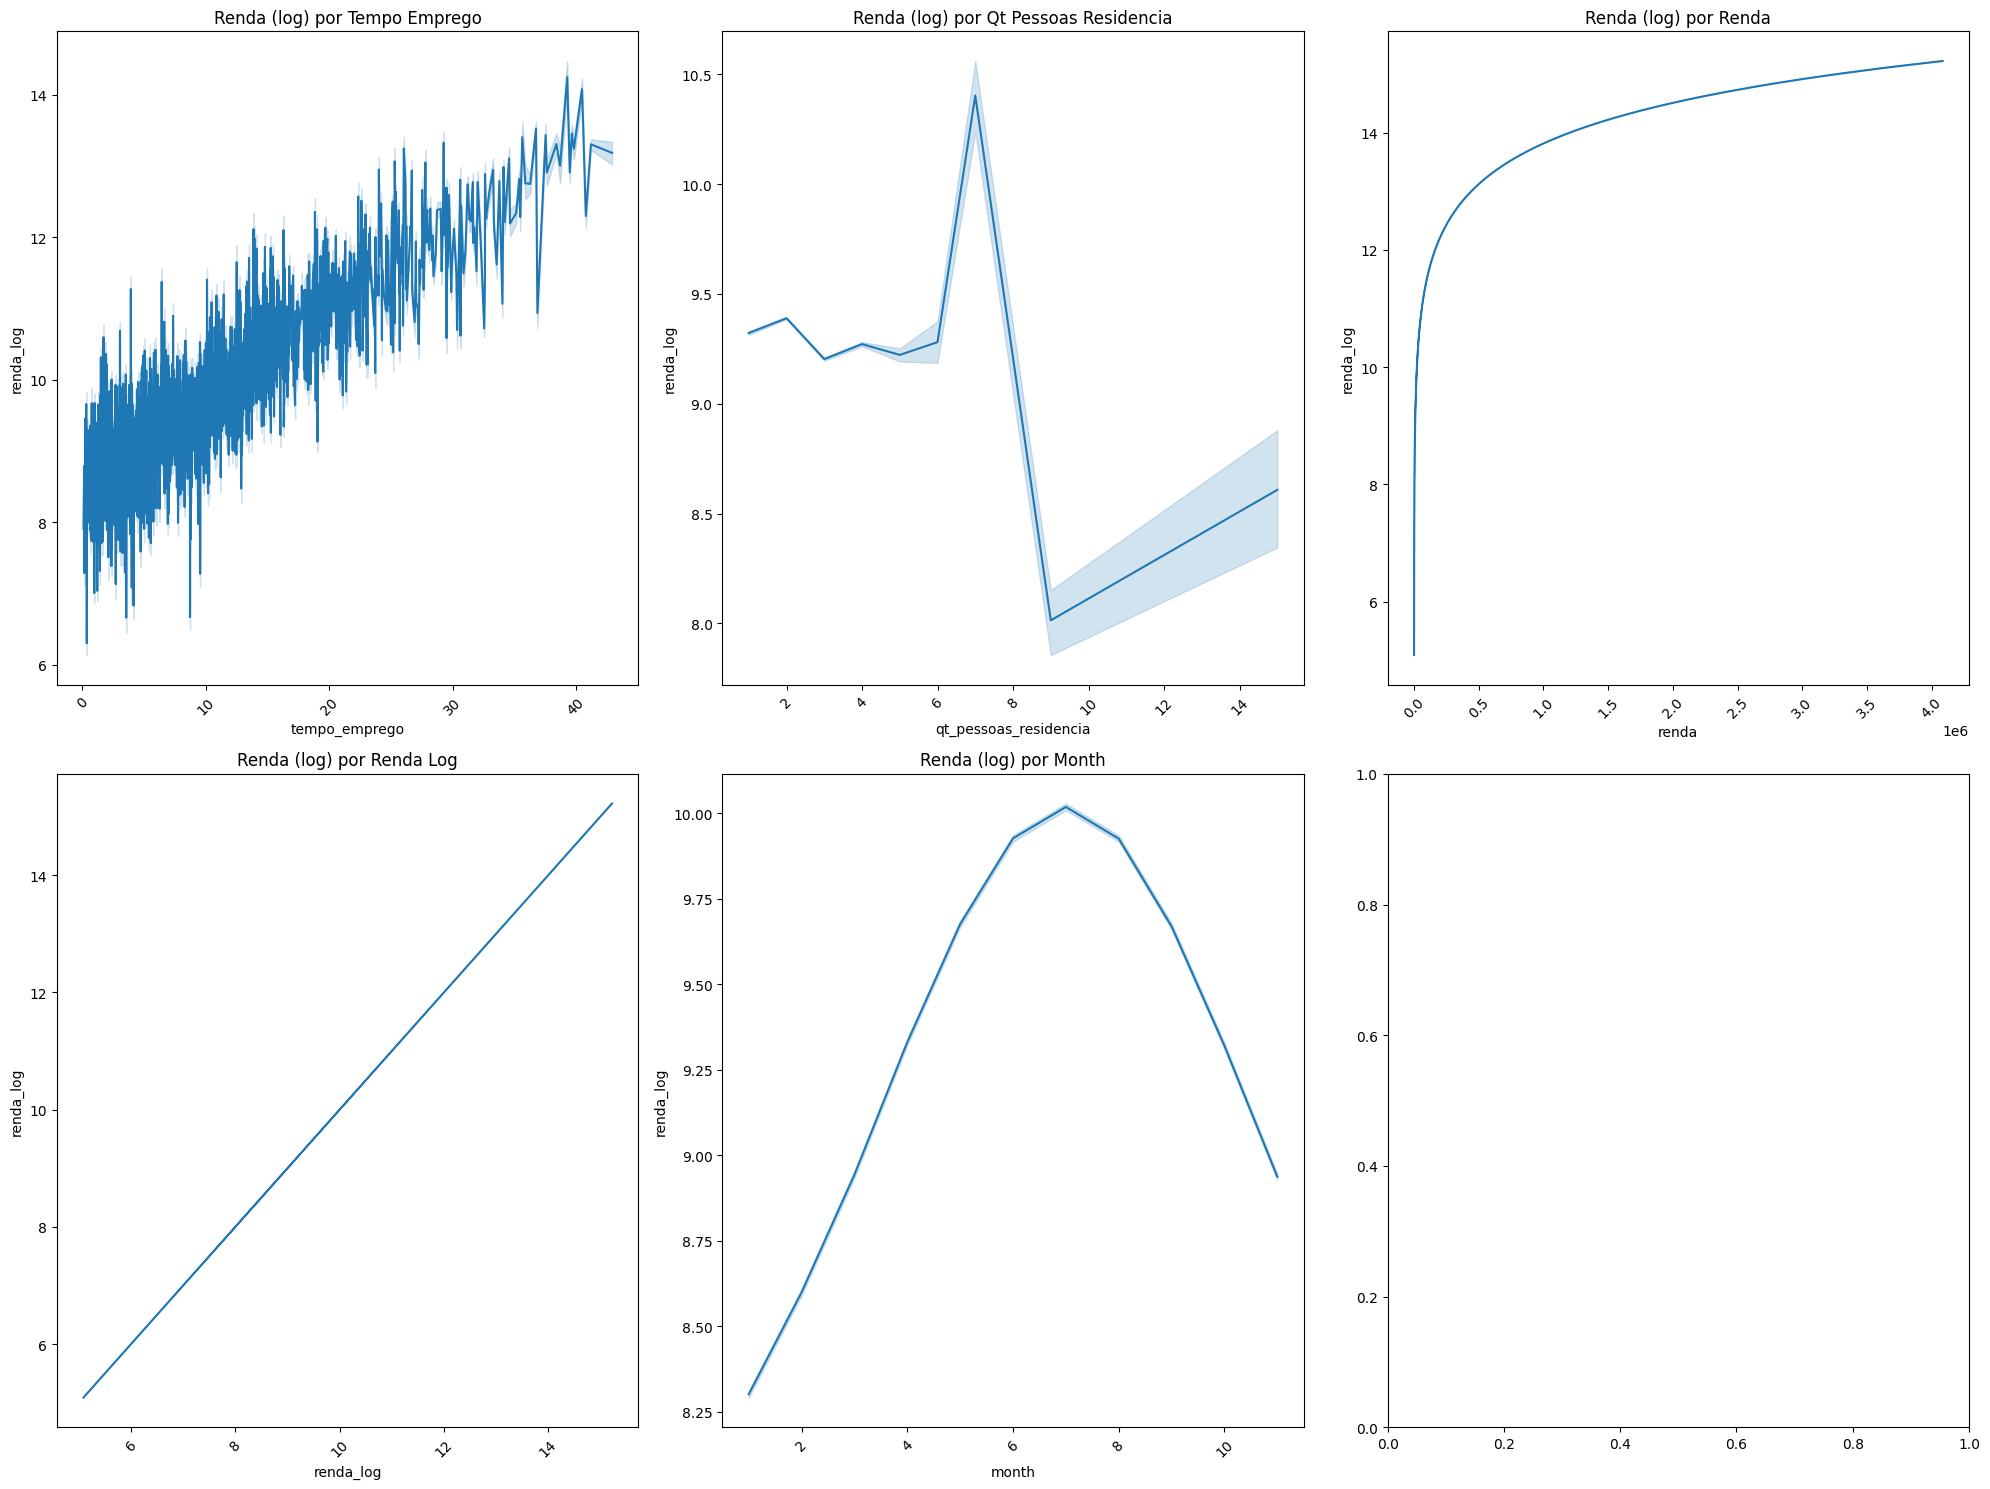

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_train,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
# ax[2,1].set_axis_off()
# ax[2,2].set_axis_off()
plt.show

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [19]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    # tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [25]:
categorias = df_train.select_dtypes("object").dtypes.index
categorias

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,348064,22063,0.059609,F,370127,0.000389,0.060372,0.058847,-2.758484,-2.744958,-2.772174,0.032845,0.046371,0.019155
M,170149,9724,0.054060,M,179873,0.000533,0.055105,0.053015,-2.862077,-2.841825,-2.882702,-0.070749,-0.050496,-0.091373


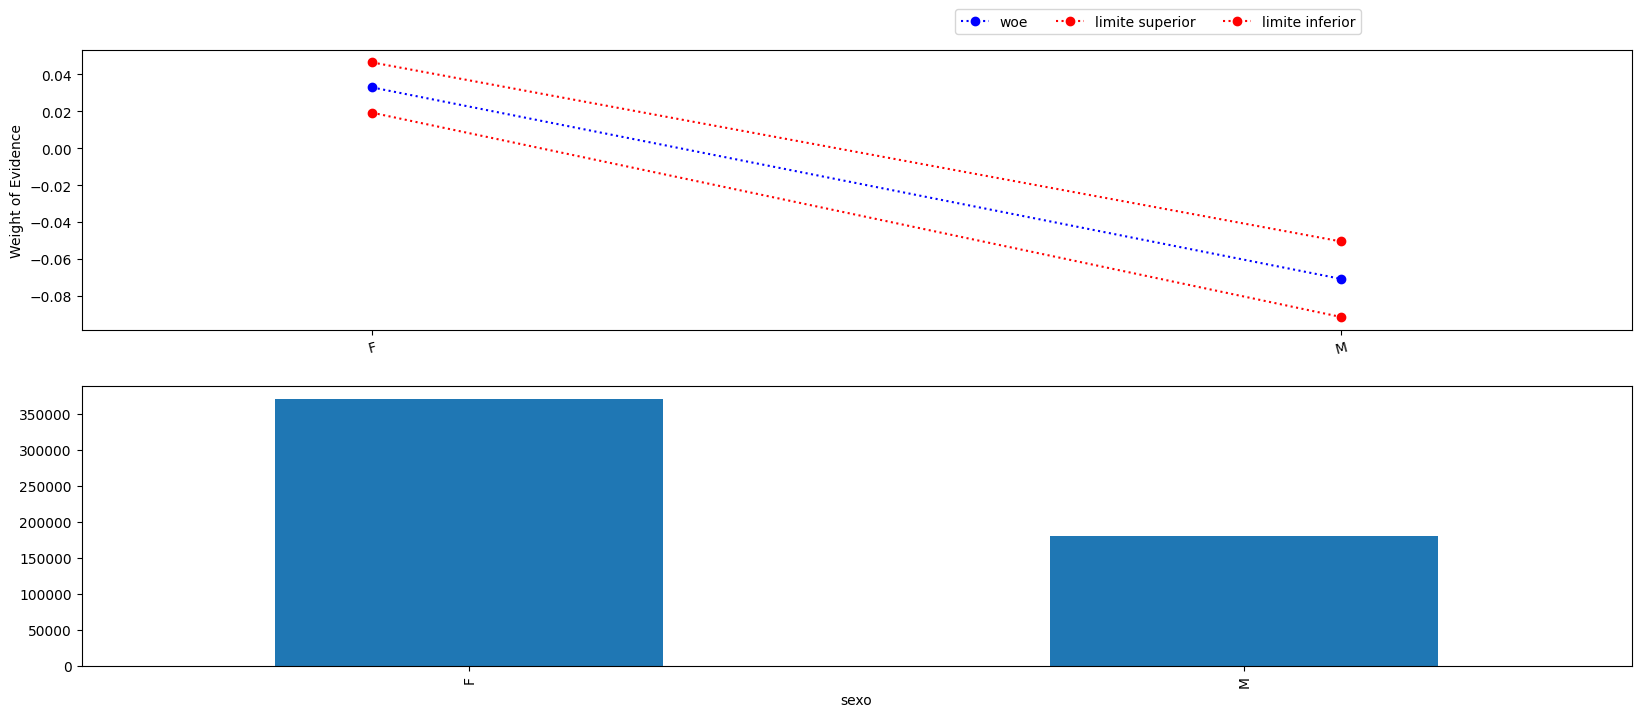

In [27]:
c = 0
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,316160,19495,0.058080,N,335655,0.000404,0.058872,0.057289,-2.786090,-2.771718,-2.800647,0.005239,0.019611,-0.009318
S,202053,12292,0.057347,S,214345,0.000502,0.058331,0.056363,-2.799581,-2.781518,-2.817938,-0.008252,0.009811,-0.026609


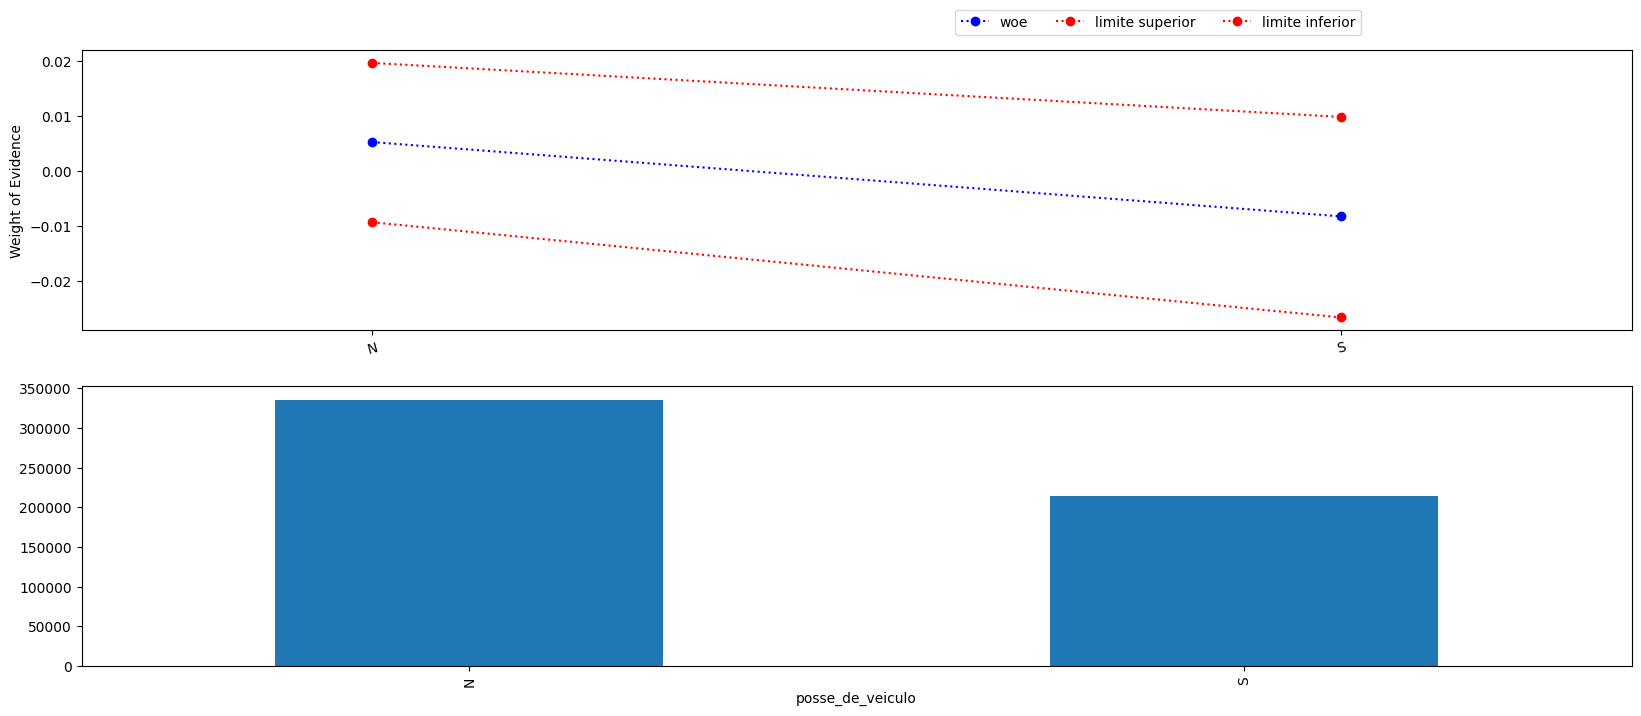

In [28]:
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,168867,11860,0.065624,N,180727,0.000582,0.066765,0.064482,-2.655940,-2.637470,-2.674711,0.135389,0.153859,0.116618
S,349346,19927,0.053963,S,369273,0.000372,0.054692,0.053234,-2.863987,-2.849802,-2.878354,-0.072658,-0.058473,-0.087025


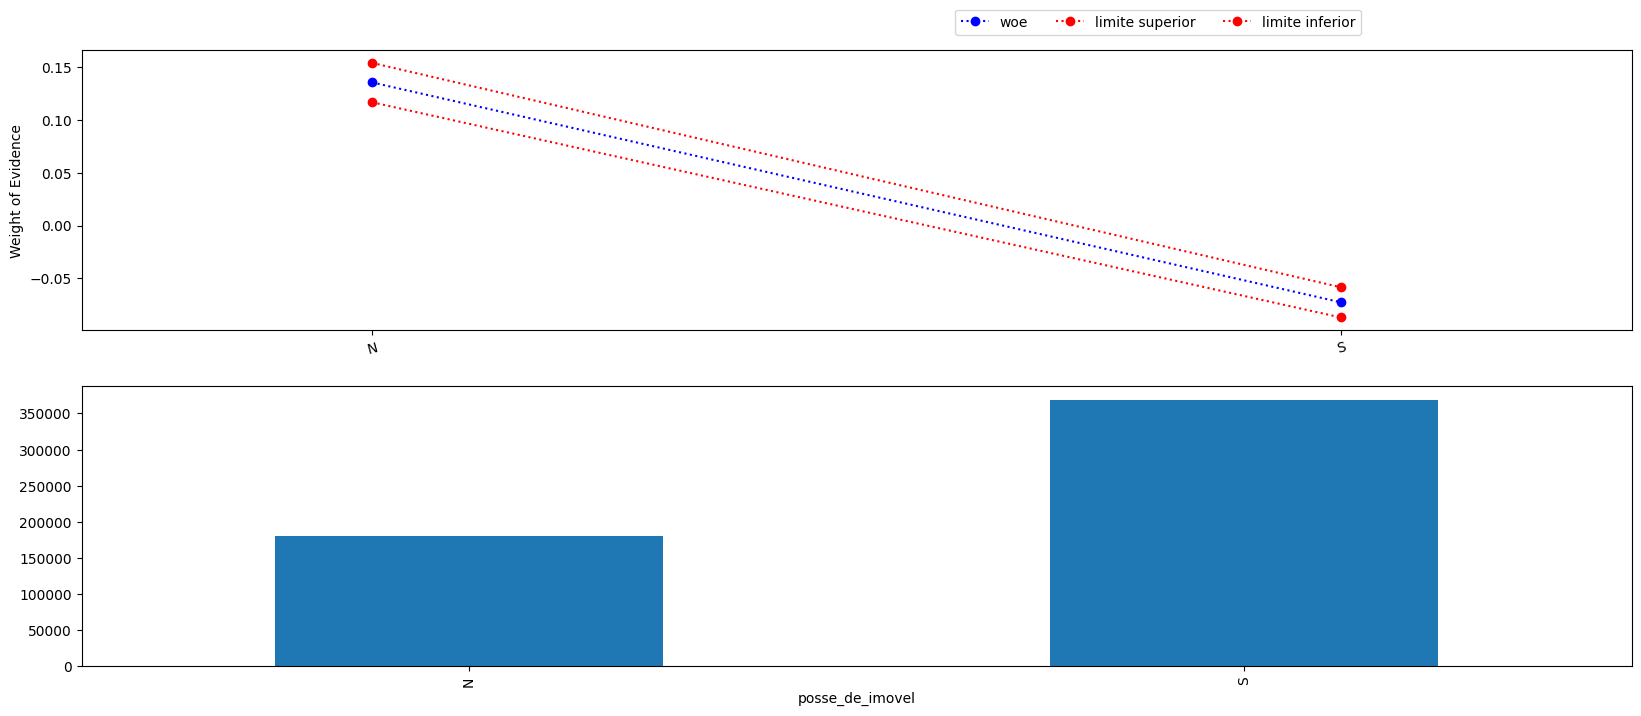

In [29]:
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,265681,17048,0.060298,Assalariado,282729,0.000448,0.061175,0.059421,-2.746263,-2.730883,-2.761855,0.045066,0.060446,0.029474
Bolsista,248,10,0.038760,Bolsista,258,0.012017,0.062424,0.015095,-3.210844,-2.709348,-4.178158,-0.419515,0.081981,-1.386829
Empresário,119389,7135,0.056392,Empresário,126524,0.000649,0.057664,0.055121,-2.817375,-2.793737,-2.841519,-0.026046,-0.002408,-0.050190
Pensionista,87128,5593,0.060321,Pensionista,92721,0.000782,0.061853,0.058788,-2.745862,-2.719143,-2.773225,0.045466,0.072186,0.018104
Servidor público,45767,2001,0.041890,Servidor público,47768,0.000917,0.043687,0.040093,-3.129916,-3.086045,-3.175625,-0.338587,-0.294716,-0.384296


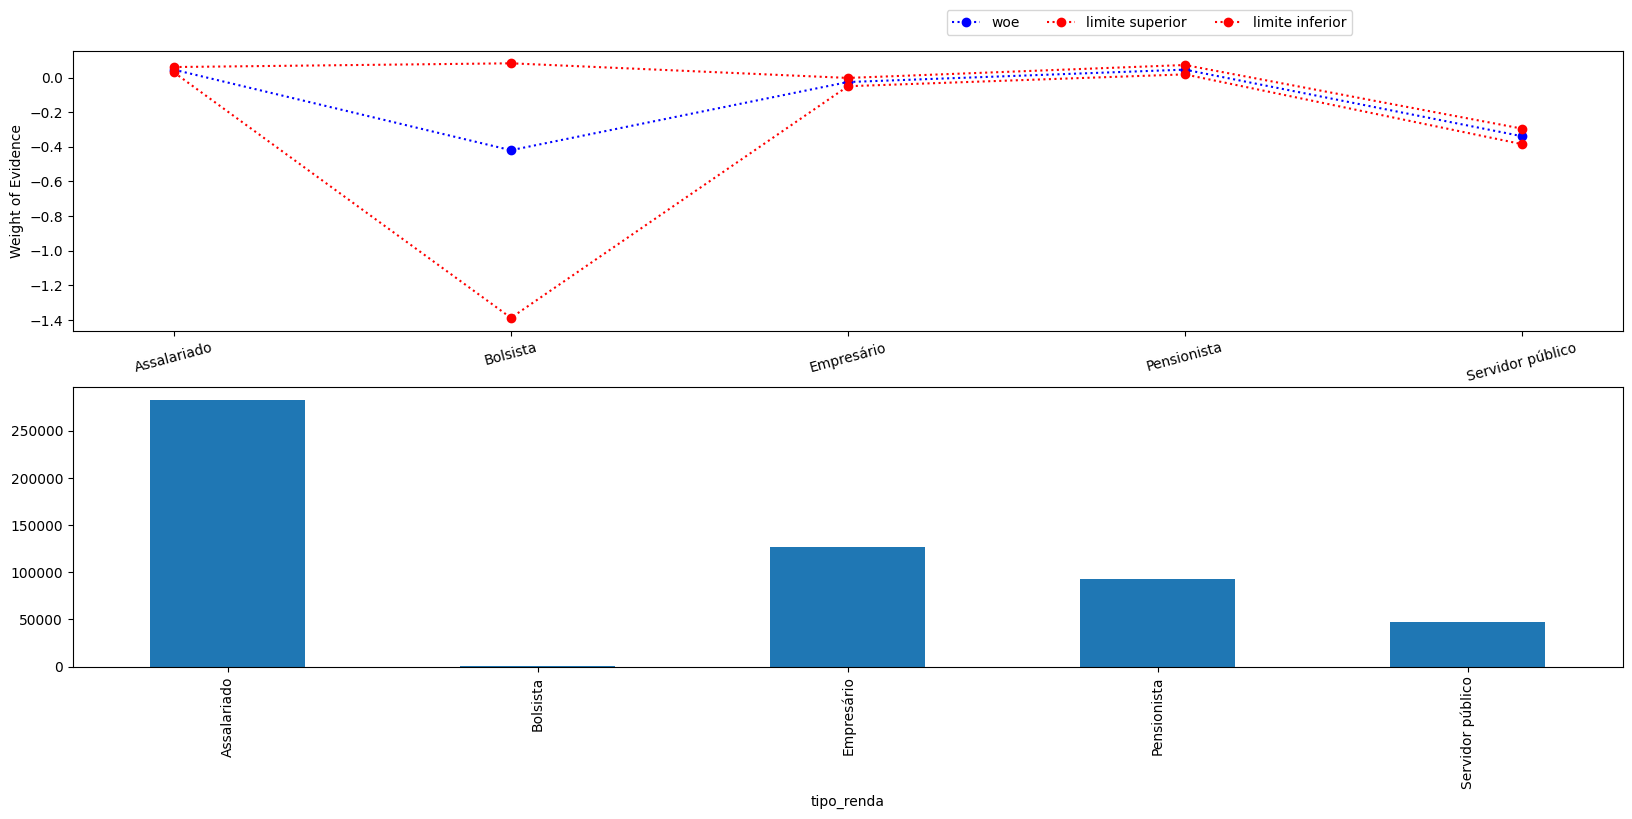

In [30]:
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,5914,417,0.065866,Fundamental,6331,0.003117,0.071978,0.059755,-2.651991,-2.556700,-2.755886,0.139337,0.234629,0.035443
Médio,349470,22115,0.059515,Médio,371585,0.000388,0.060276,0.058755,-2.760162,-2.746652,-2.773834,0.031167,0.044677,0.017495
Pós graduação,564,37,0.061564,Pós graduação,601,0.009805,0.080820,0.042309,-2.724136,-2.431264,-3.119535,0.067193,0.360065,-0.328206
Superior completo,142005,7896,0.052675,Superior completo,149901,0.000577,0.053806,0.051544,-2.889506,-2.867070,-2.912401,-0.098177,-0.075741,-0.121072
Superior incompleto,20260,1322,0.061255,Superior incompleto,21582,0.001632,0.064454,0.058055,-2.729503,-2.675176,-2.786550,0.061826,0.116153,0.004779


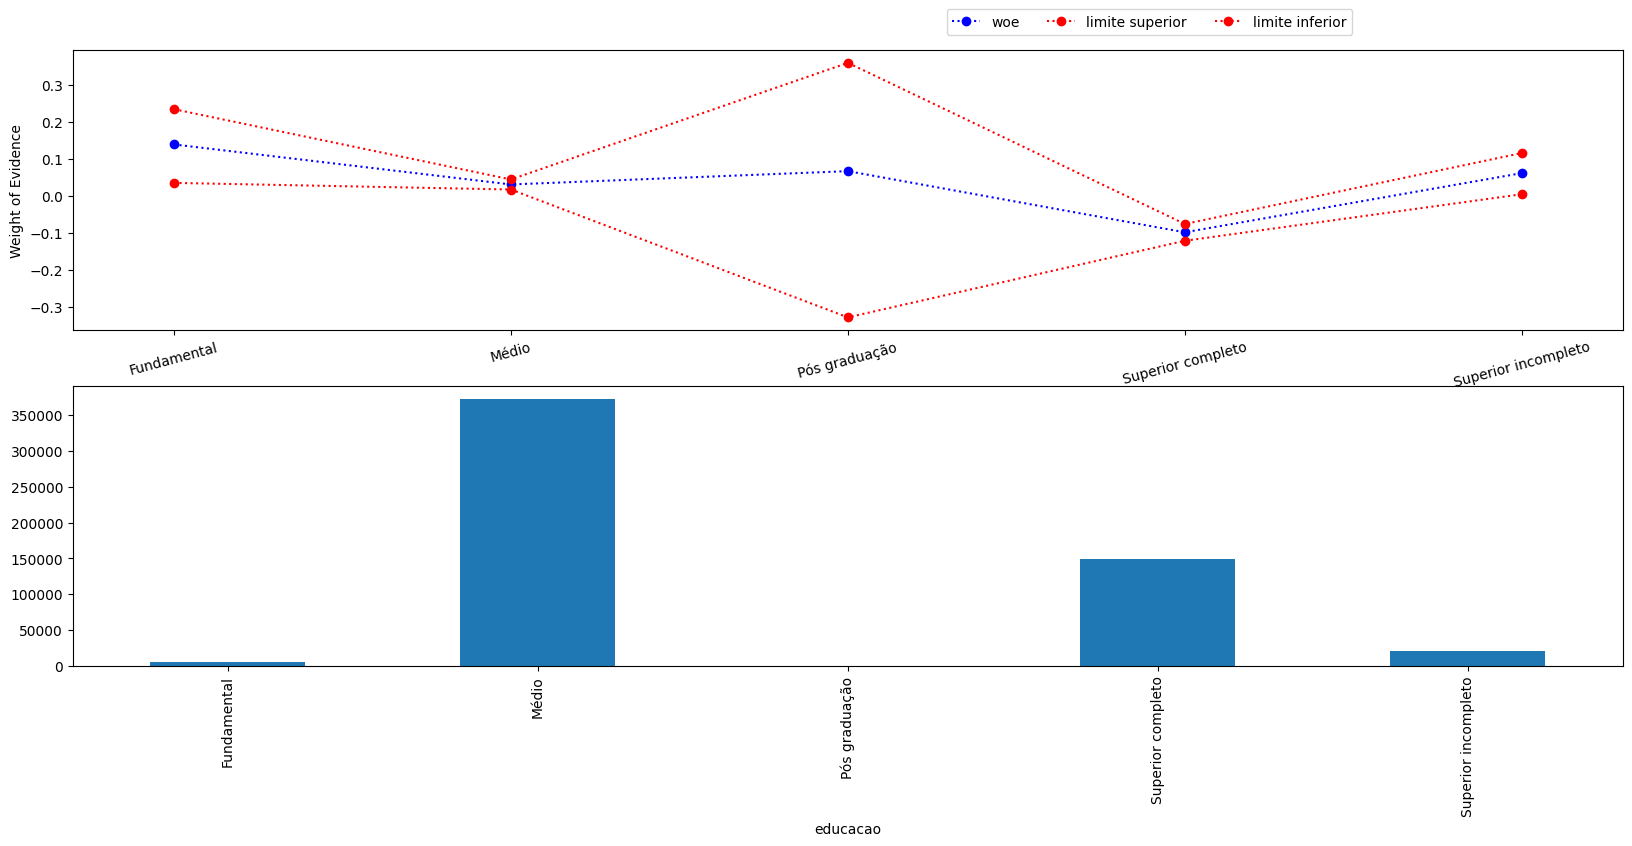

In [31]:
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,364299,21939,0.056802,Casado,386238,0.000372,0.057532,0.056072,-2.809709,-2.796166,-2.823417,-0.018380,-0.004837,-0.032088
Separado,29429,1885,0.060197,Separado,31314,0.001344,0.062831,0.057562,-2.748053,-2.702411,-2.795604,0.043276,0.088918,-0.004275
Solteiro,62974,4010,0.059865,Solteiro,66984,0.000917,0.061662,0.058068,-2.753931,-2.722448,-2.786310,0.037398,0.068880,0.005019
União,39540,2671,0.063277,União,42211,0.001185,0.065600,0.060955,-2.694860,-2.656330,-2.734732,0.096469,0.134999,0.056597
Viúvo,21971,1282,0.055133,Viúvo,23253,0.001497,0.058066,0.052199,-2.841302,-2.786347,-2.899083,-0.049973,0.004981,-0.107754


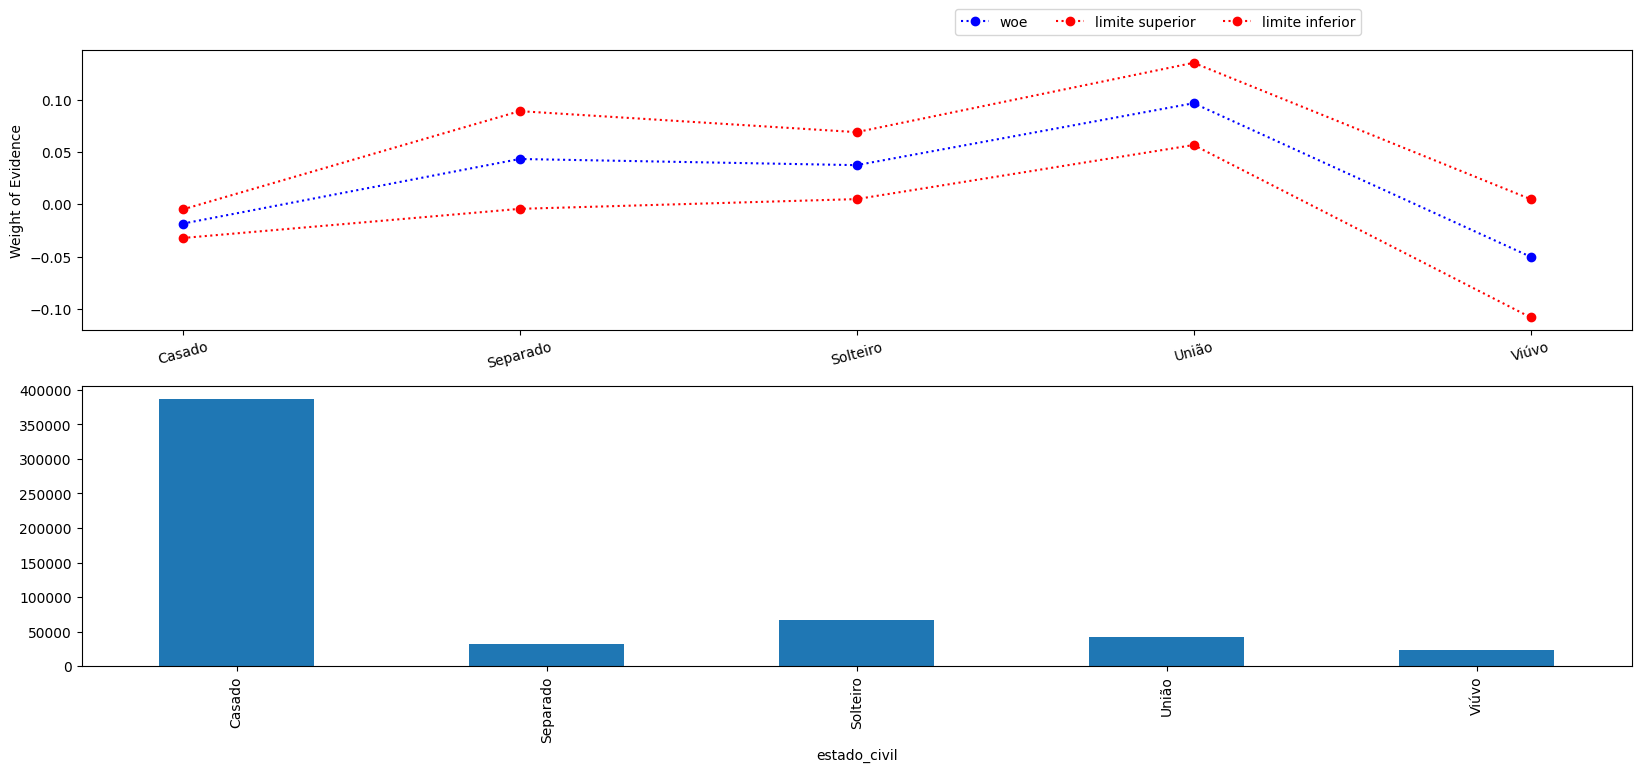

In [32]:
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,115886,18567,0.138093,F,134453,0.000941,0.139937,0.136249,-1.831221,-1.815814,-1.846802,0.032413,0.047821,0.016832
M,57258,8289,0.126459,M,65547,0.001298,0.129003,0.123914,-1.932638,-1.909800,-1.955873,-0.069004,-0.046165,-0.092238


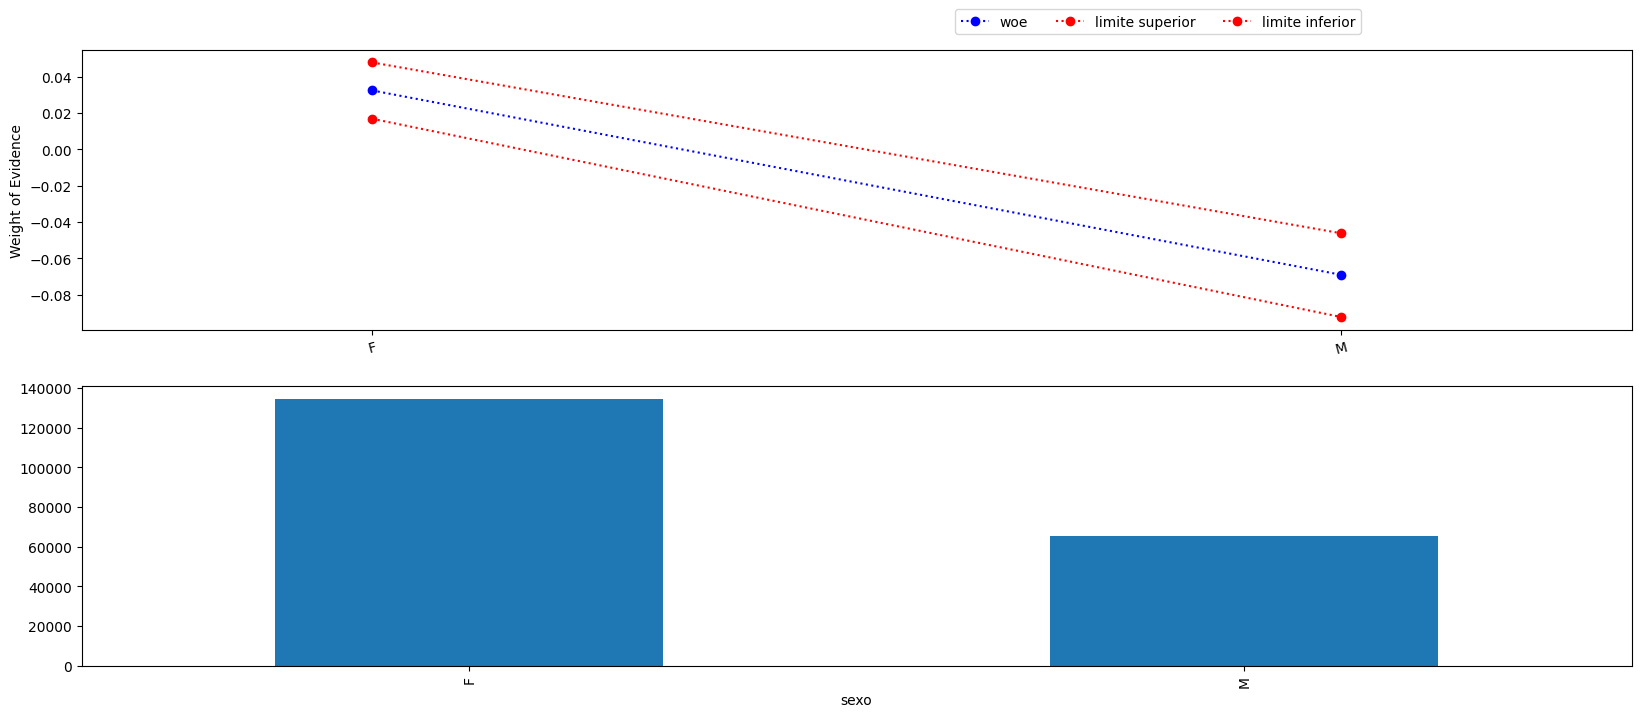

In [36]:
c = 0
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,105712,16587,0.135627,N,122299,0.000979,0.137546,0.133708,-1.852099,-1.835827,-1.868567,0.011535,0.027807,-0.004932
S,67432,10269,0.132160,S,77701,0.001215,0.134542,0.129779,-1.881990,-1.861385,-1.902913,-0.018356,0.002250,-0.039278


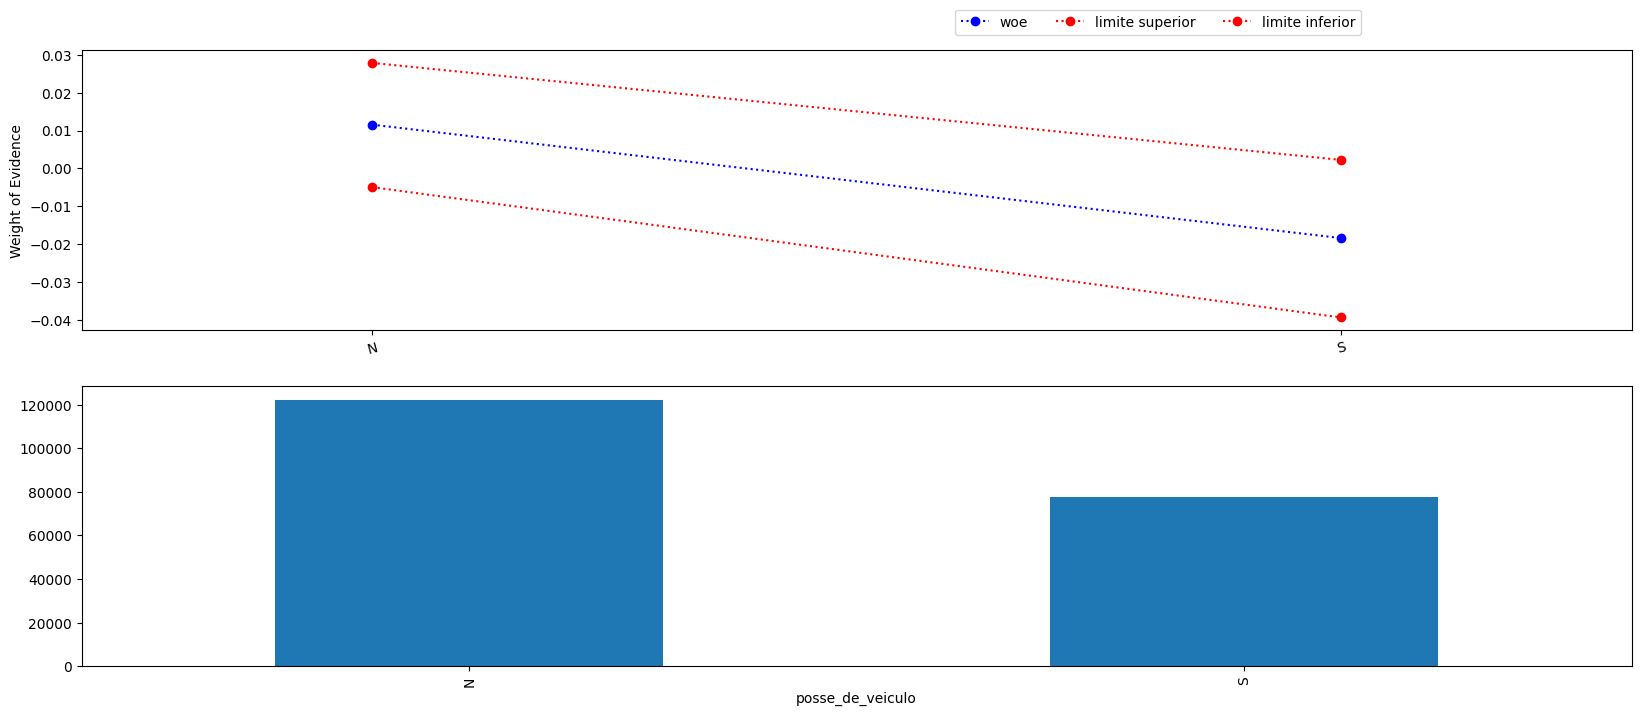

In [37]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,55648,9933,0.151462,N,65581,0.001400,0.154205,0.148718,-1.723184,-1.701991,-1.744694,0.140451,0.161643,0.118941
S,117496,16923,0.125897,S,134419,0.000905,0.127671,0.124124,-1.937731,-1.921712,-1.953944,-0.074096,-0.058077,-0.090309


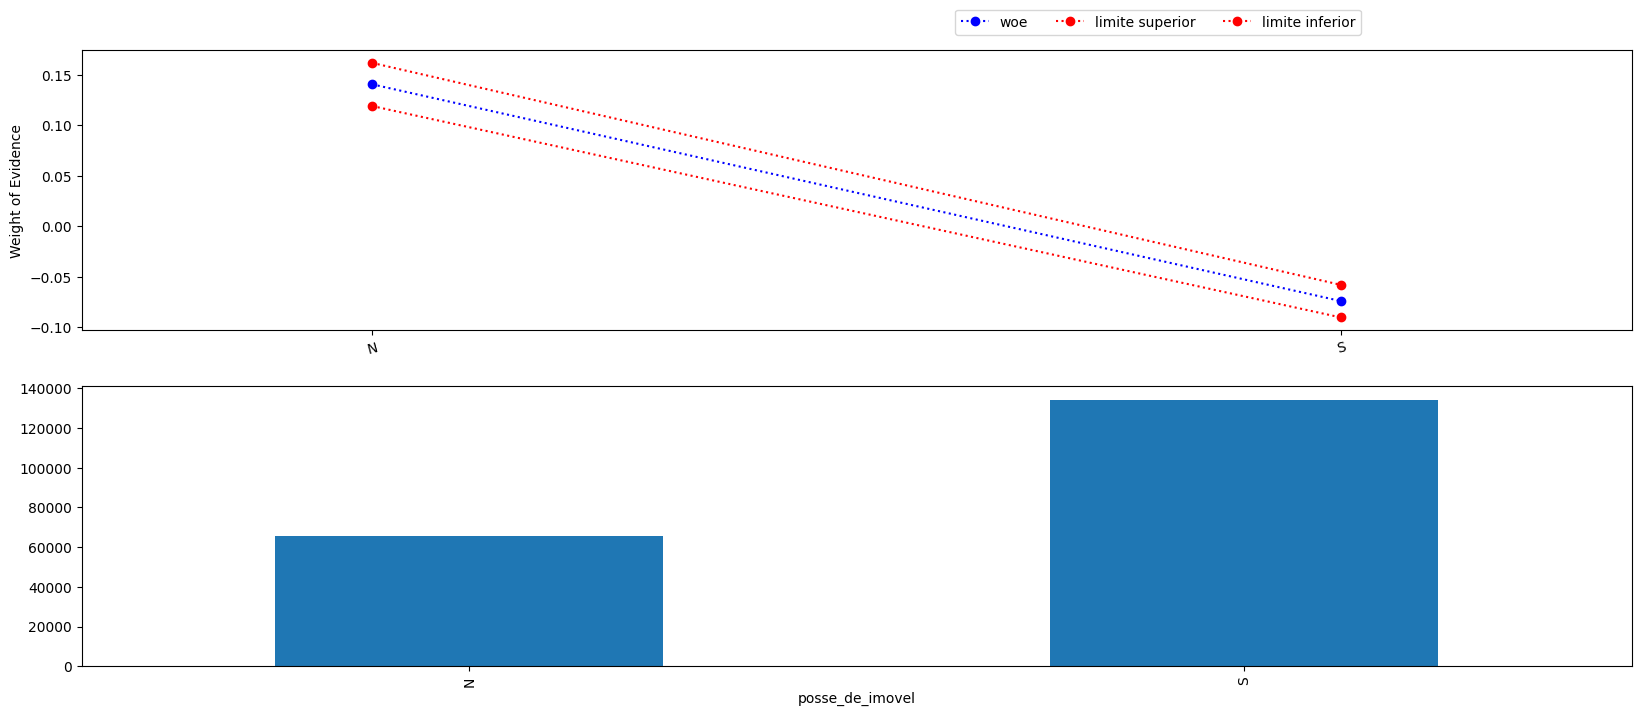

In [38]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,88846,14165,0.137510,Assalariado,103011,0.001073,0.139613,0.135407,-1.836130,-1.818511,-1.853978,0.027504,0.045124,0.009656
Bolsista,98,5,0.048544,Bolsista,103,0.021176,0.090546,0.006541,-2.975530,-2.306986,-5.023047,-1.111895,-0.443352,-3.159413
Empresário,40119,6069,0.131398,Empresário,46188,0.001572,0.134479,0.128317,-1.888656,-1.861925,-1.915925,-0.025022,0.001709,-0.052290
Pensionista,28697,4847,0.144497,Pensionista,33544,0.001920,0.148259,0.140734,-1.778433,-1.748318,-1.809206,0.085202,0.115316,0.054428
Servidor público,15384,1770,0.103183,Servidor público,17154,0.002323,0.107735,0.098630,-2.162348,-2.114084,-2.212536,-0.298714,-0.250450,-0.348901


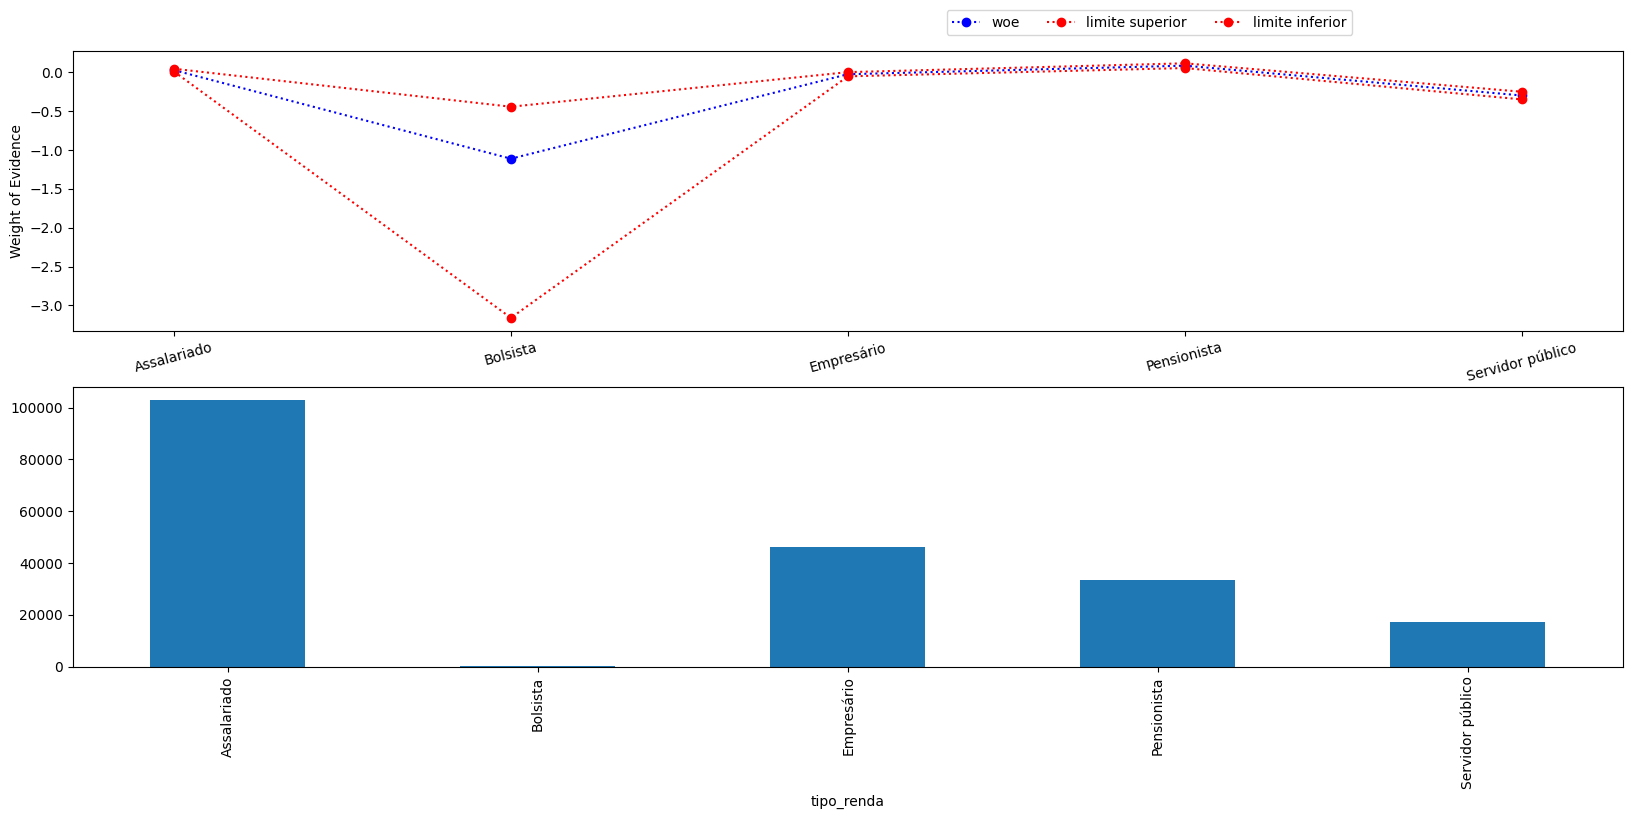

In [39]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,1875,369,0.164439,Fundamental,2244,0.007825,0.179783,0.149094,-1.625567,-1.517816,-1.741727,0.238067,0.345818,0.121907
Médio,116636,18615,0.137633,Médio,135251,0.000937,0.139469,0.135797,-1.835090,-1.819707,-1.850647,0.028544,0.043928,0.012987
Pós graduação,189,22,0.104265,Pós graduação,211,0.021039,0.145739,0.062791,-2.150705,-1.768416,-2.703089,-0.287070,0.095219,-0.839455
Superior completo,47679,6726,0.123628,Superior completo,54405,0.001411,0.126394,0.120862,-1.958510,-1.933223,-1.984289,-0.094876,-0.069589,-0.120654
Superior incompleto,6765,1124,0.142477,Superior incompleto,7889,0.003935,0.150191,0.134763,-1.794869,-1.733102,-1.859490,0.068766,0.130532,0.004145


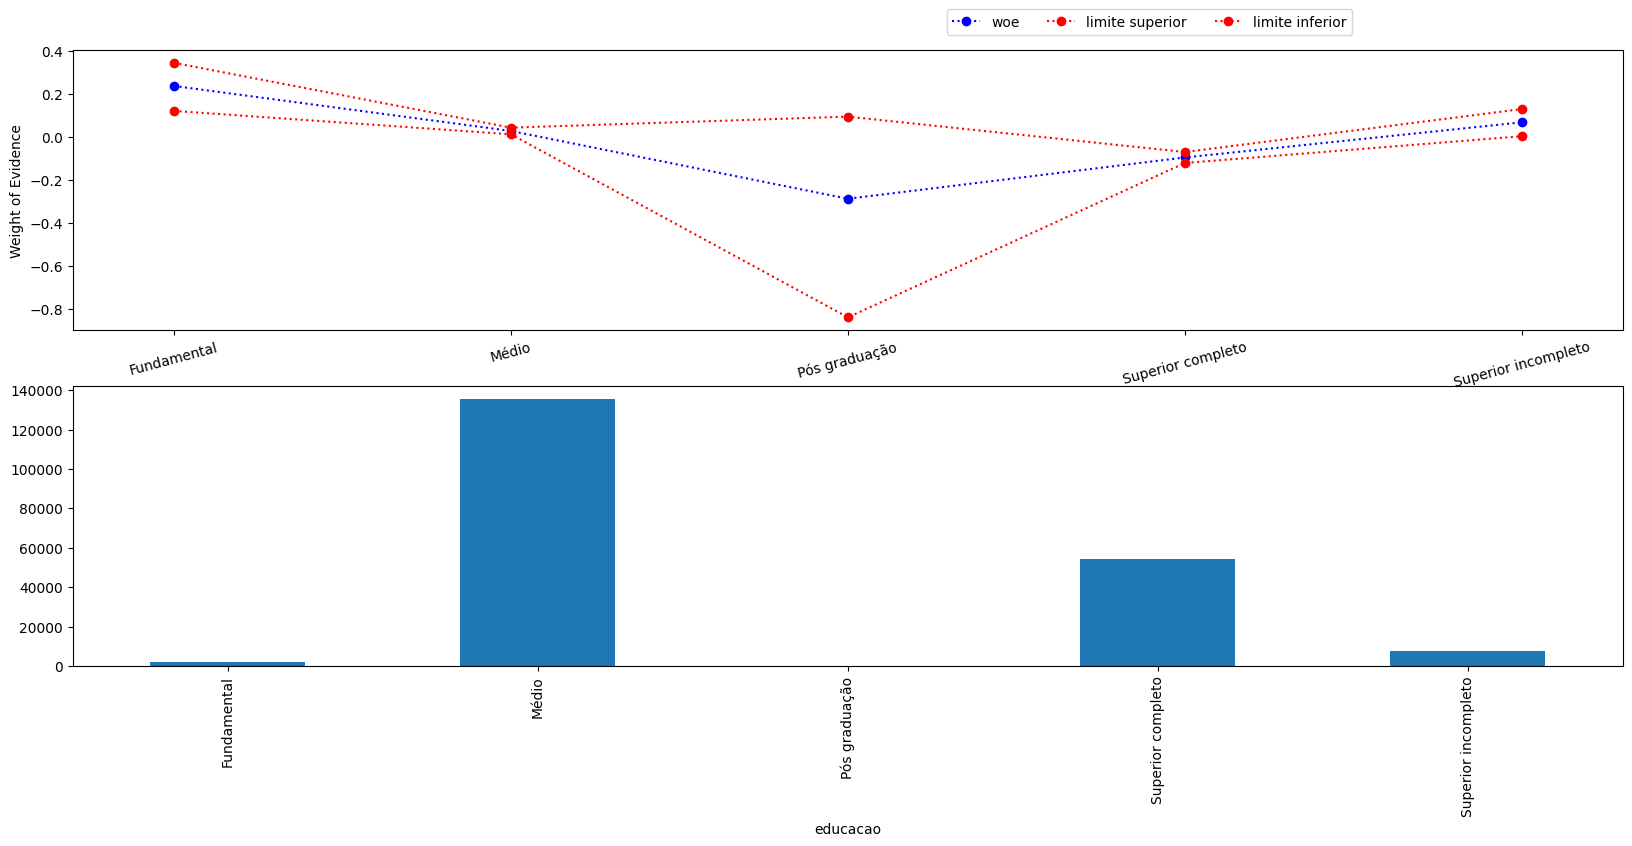

In [40]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,121654,18580,0.132493,Casado,140234,0.000905,0.134267,0.130718,-1.879095,-1.863744,-1.894622,-0.015461,-0.000110,-0.030987
Separado,9661,1596,0.141778,Separado,11257,0.003288,0.148223,0.135334,-1.800597,-1.748607,-1.854598,0.063038,0.115027,0.009037
Solteiro,21240,3435,0.139210,Solteiro,24675,0.002204,0.143529,0.134890,-1.821869,-1.786282,-1.858394,0.041765,0.077352,0.005240
União,13306,2168,0.140106,União,15474,0.002790,0.145575,0.134637,-1.814410,-1.769735,-1.860569,0.049224,0.093899,0.003065
Viúvo,7283,1077,0.128828,Viúvo,8360,0.003664,0.136010,0.121645,-1.911363,-1.848832,-1.976940,-0.047729,0.014802,-0.113305


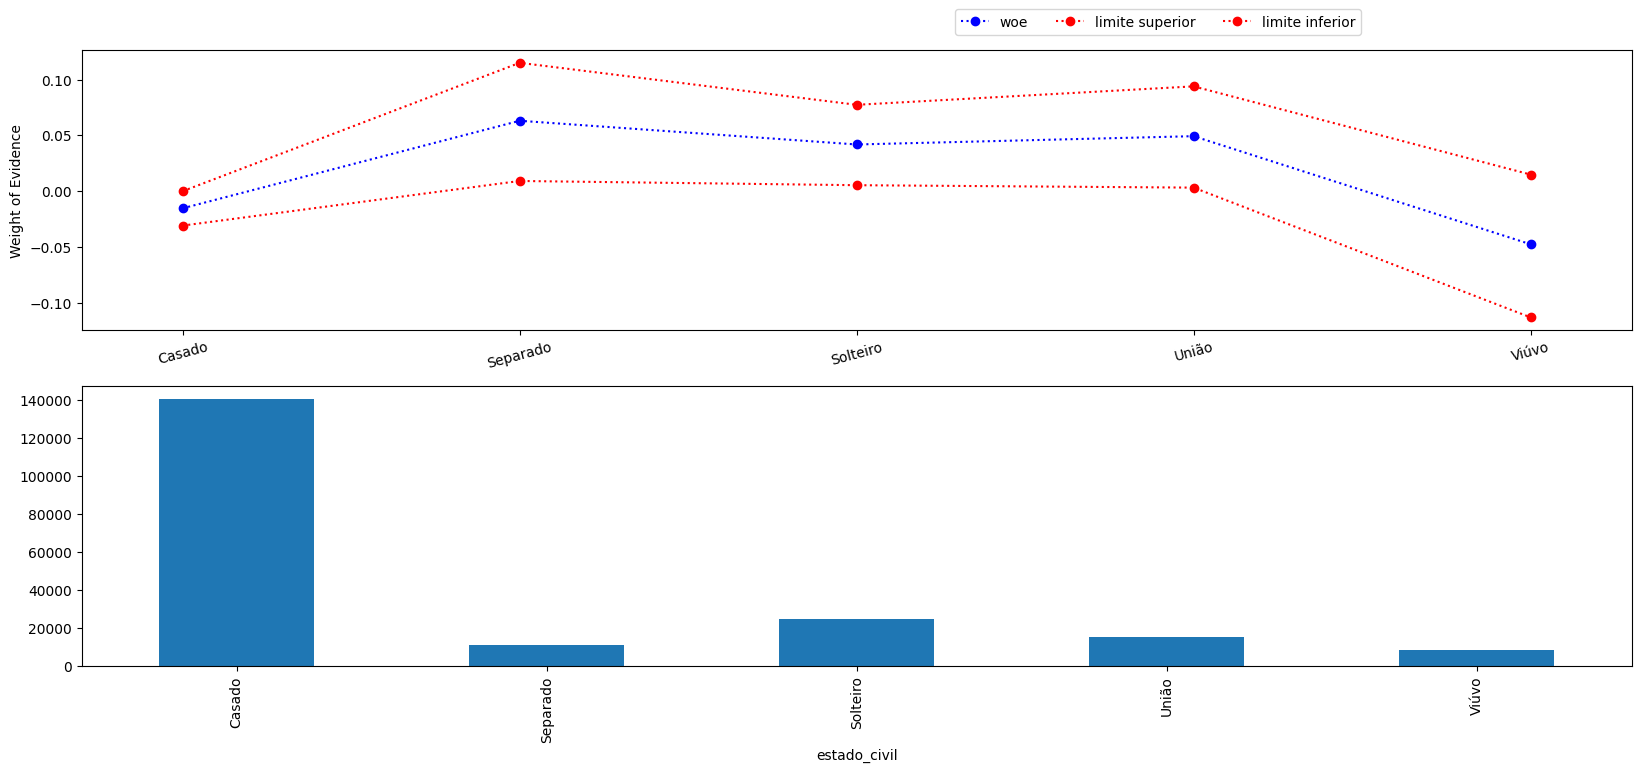

In [41]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1767152406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,2418,404,0.143161,Aluguel,2822,0.006593,0.156088,0.130233,-1.789281,-1.687625,-1.898898,0.074353,0.176010,-0.035263
Casa,156025,23859,0.132635,Casa,179884,0.000800,0.134203,0.131068,-1.877855,-1.864298,-1.891548,-0.014220,-0.000663,-0.027914
Com os pais,7294,1419,0.162860,Com os pais,8713,0.003956,0.170614,0.155106,-1.637100,-1.581281,-1.695102,0.226535,0.282354,0.168532
Comunitário,738,114,0.133803,Comunitário,852,0.011663,0.156695,0.110911,-1.867745,-1.683027,-2.081473,-0.004111,0.180607,-0.217839
Estúdio,1299,158,0.108442,Estúdio,1457,0.008146,0.124421,0.092463,-2.106755,-1.951213,-2.283927,-0.243121,-0.087579,-0.420293
Governamental,5370,902,0.143814,Governamental,6272,0.004431,0.152500,0.135128,-1.783969,-1.715129,-1.856360,0.079666,0.148505,0.007275


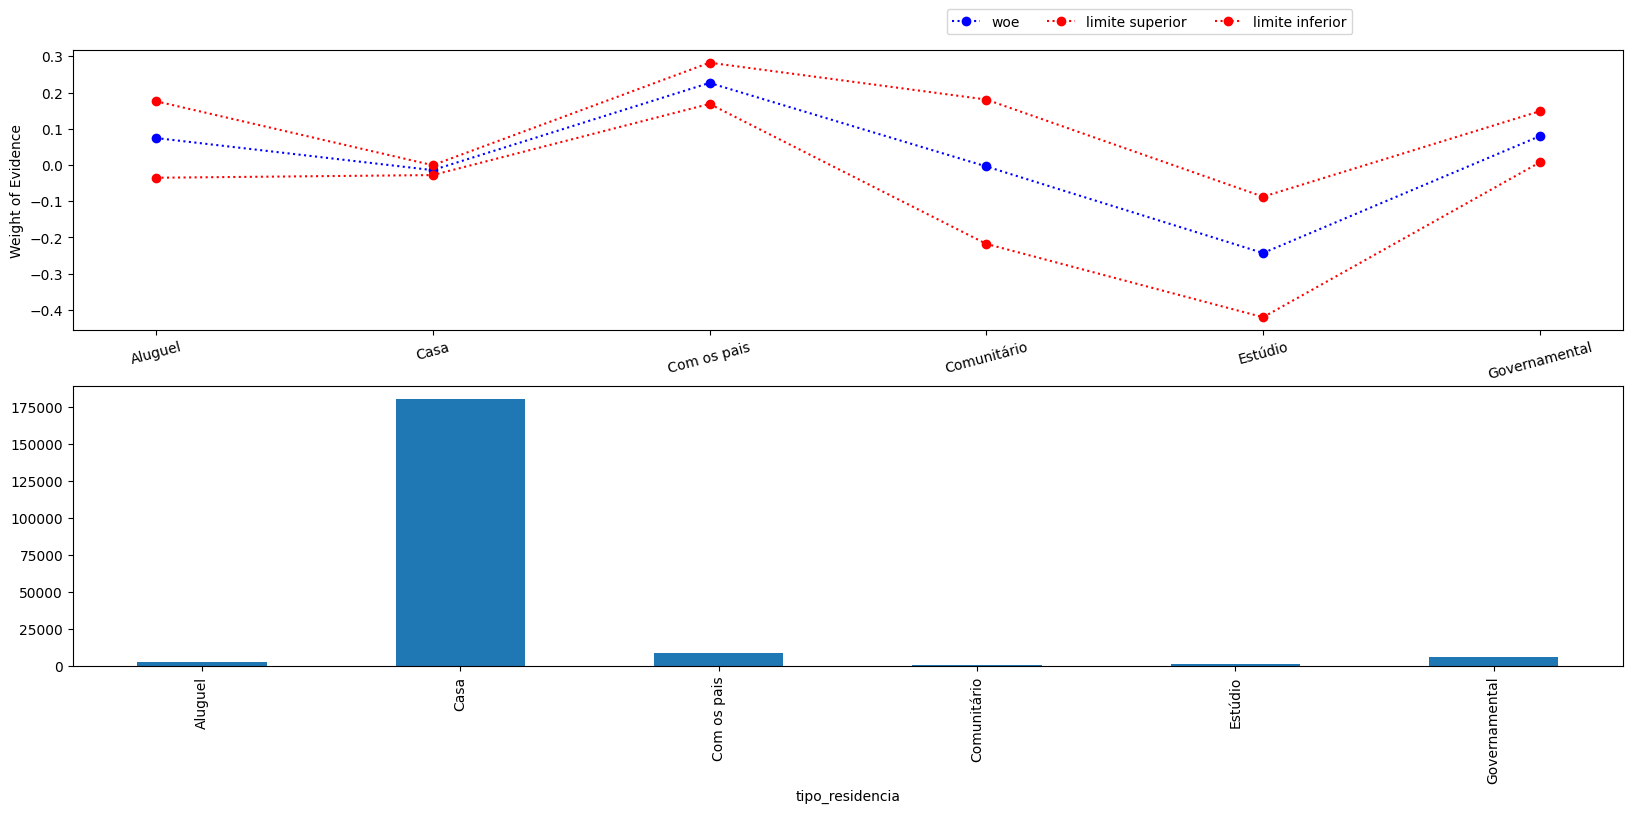

In [42]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

In [44]:

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, _ = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    # tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [46]:
continuas = df_train.select_dtypes(['int64','float64']).dtypes.index
continuas

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'renda_log'],
      dtype='object')

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


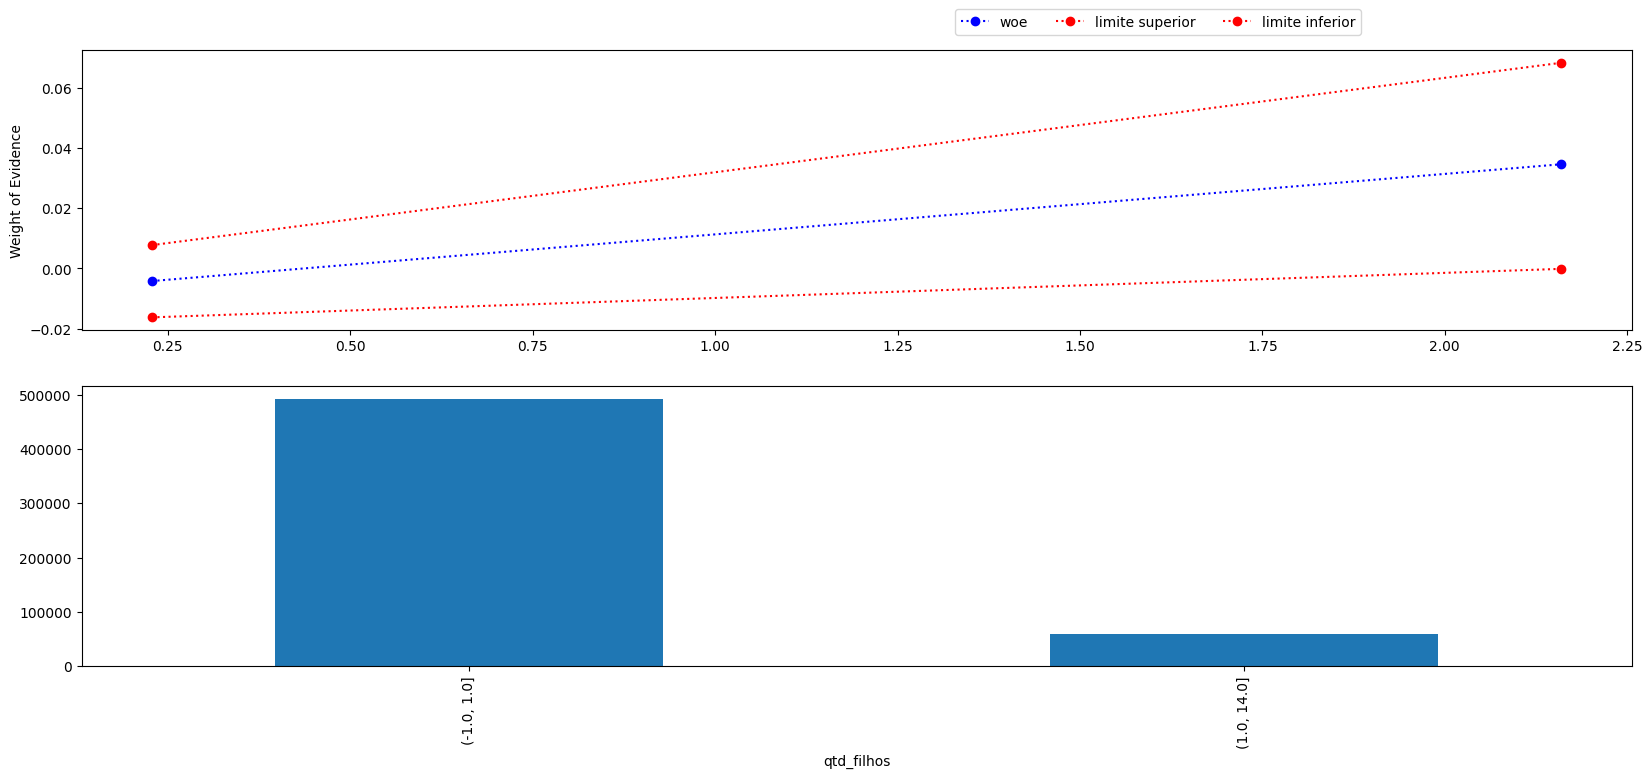

In [47]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


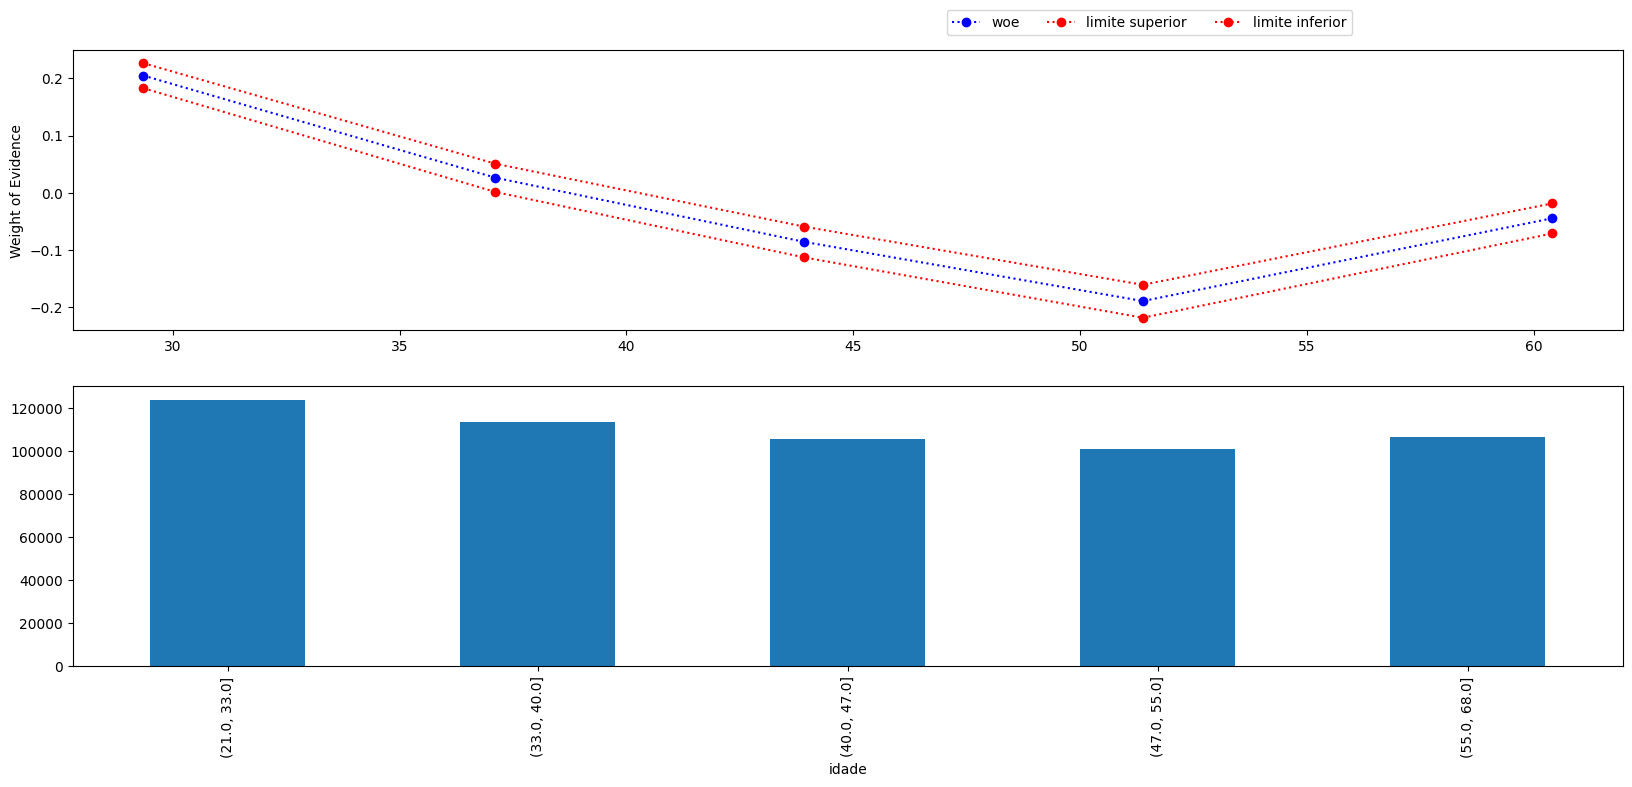

In [48]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


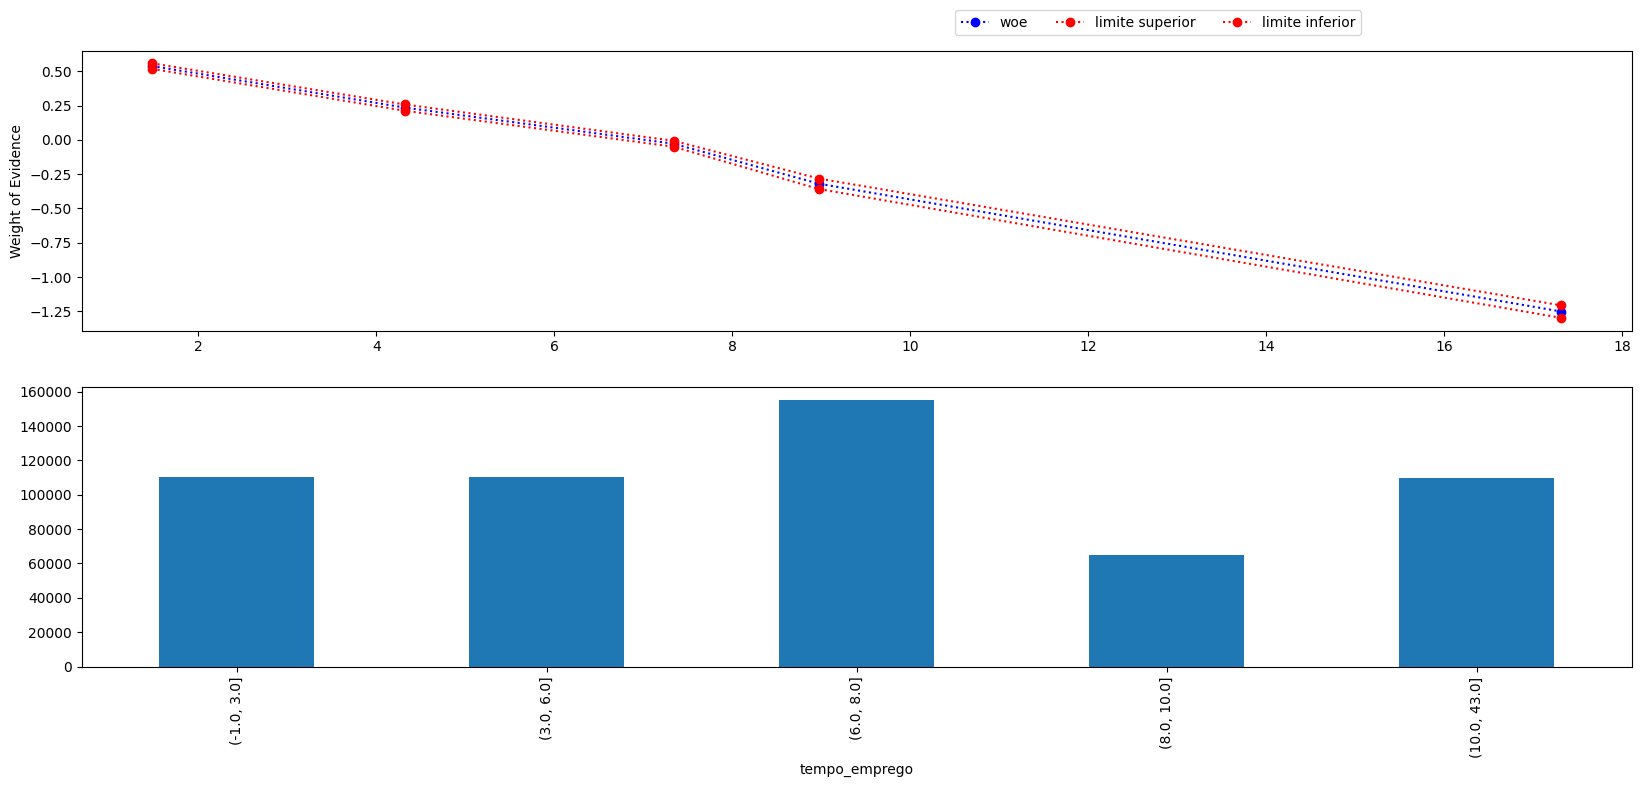

In [49]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


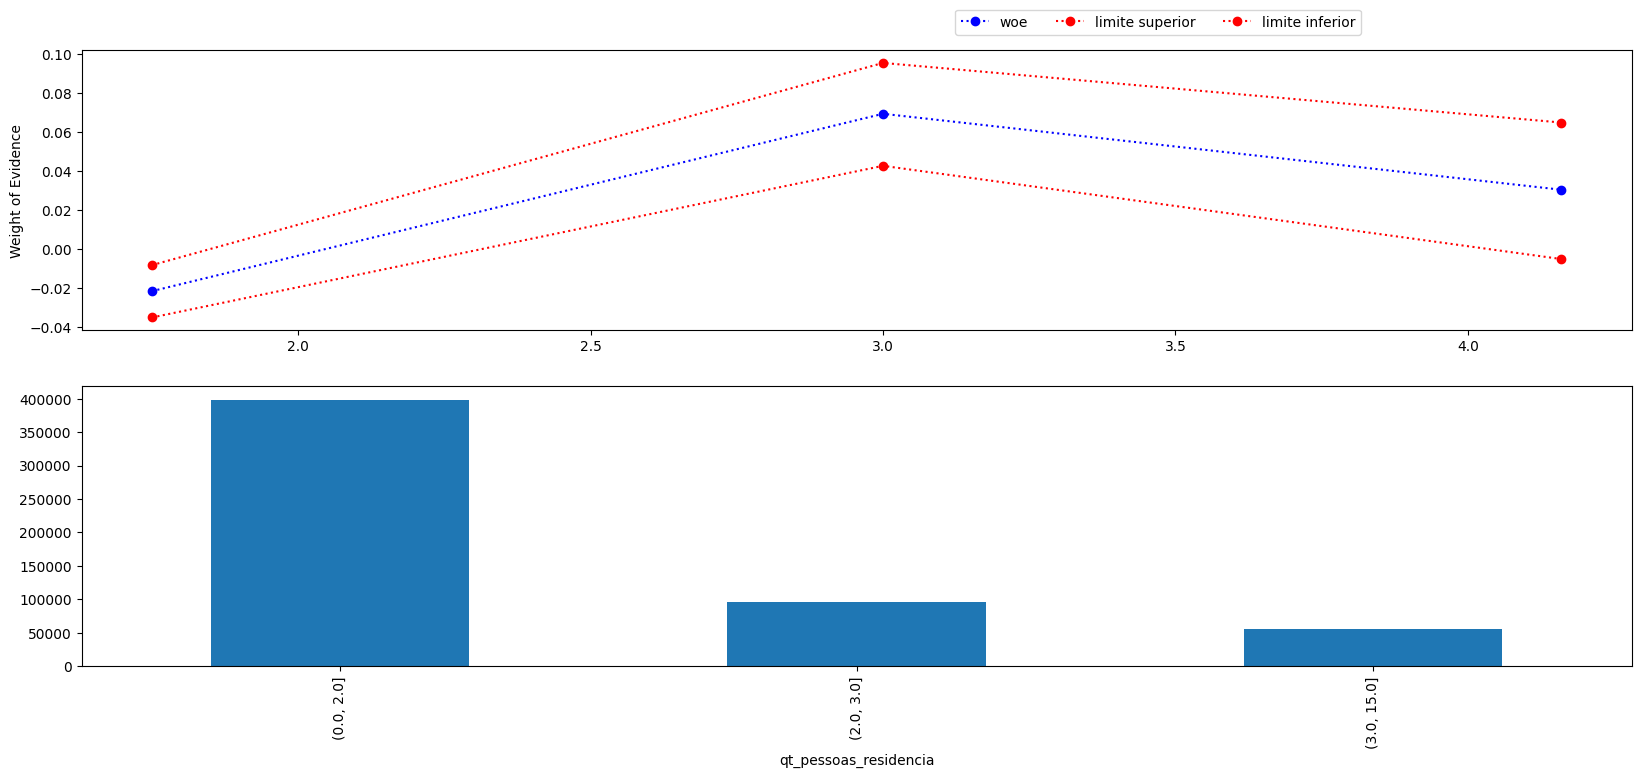

In [50]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


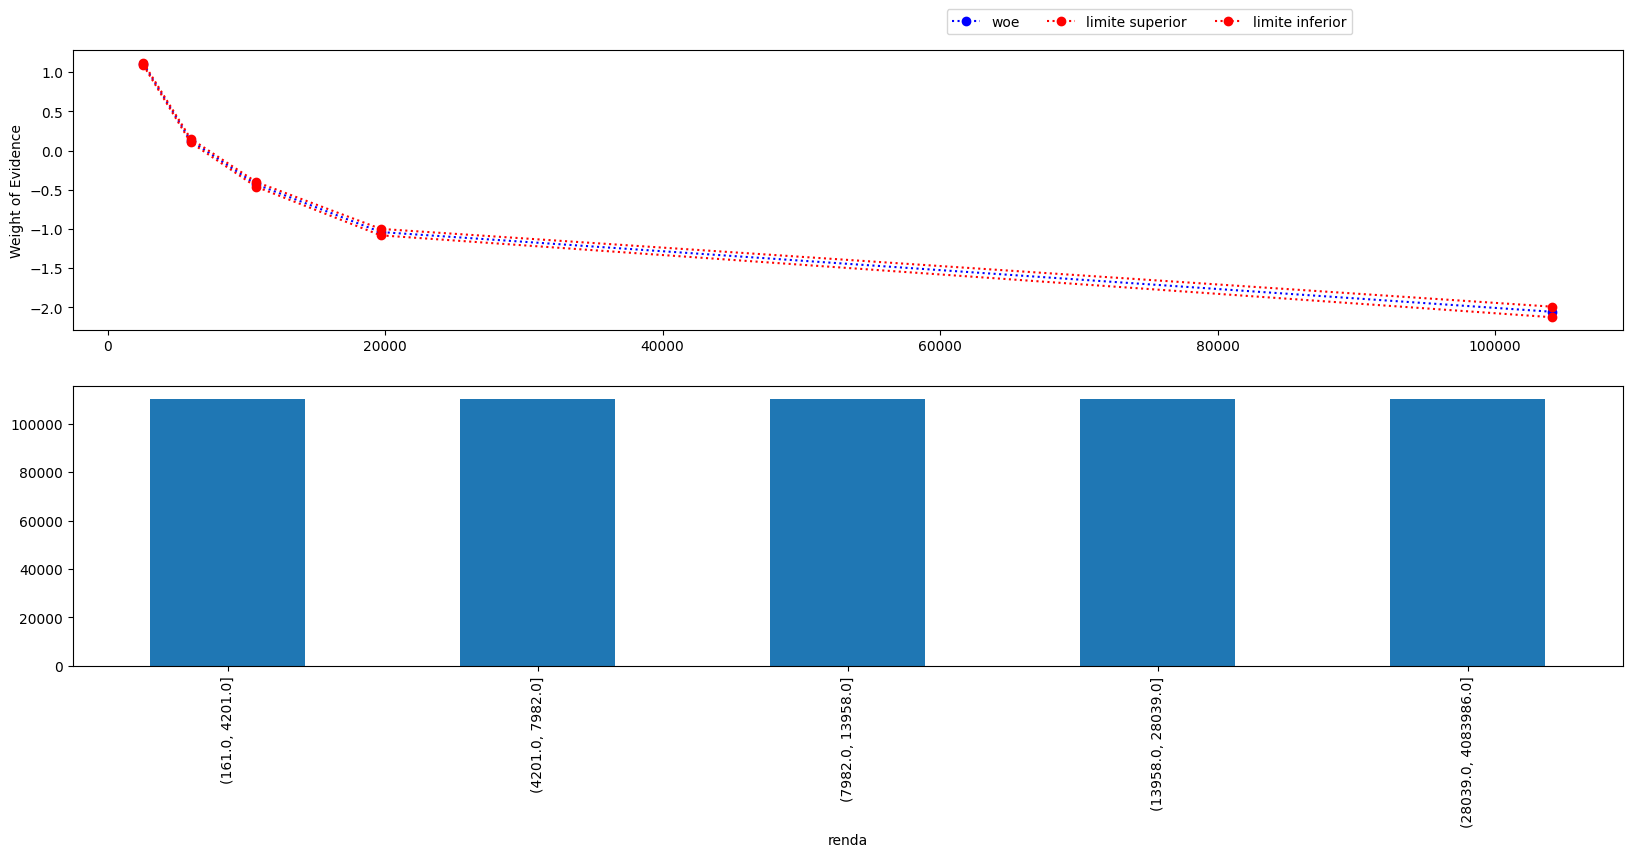

In [51]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


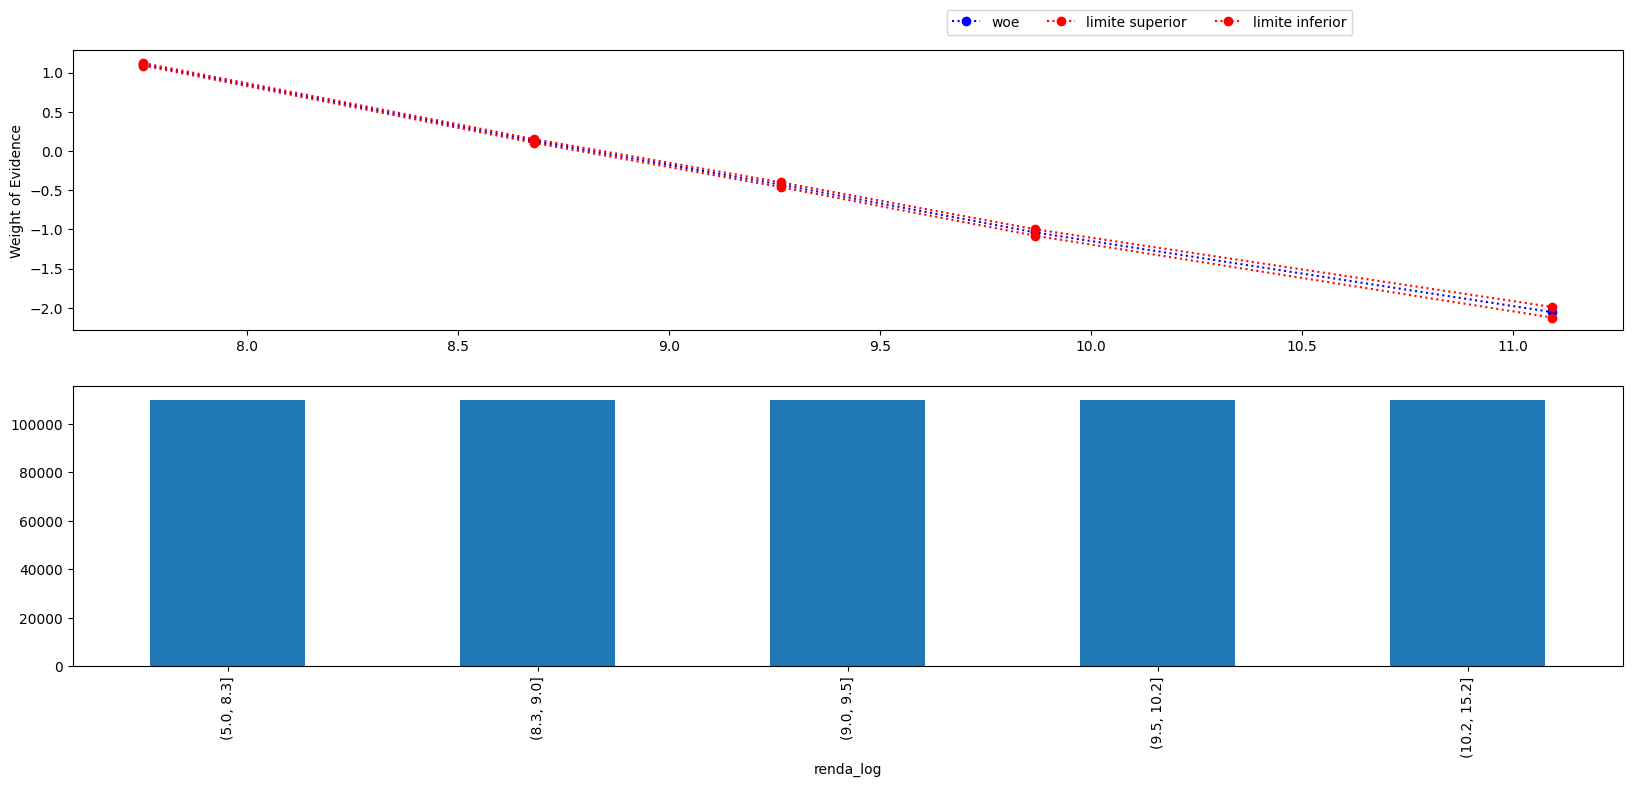

In [52]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


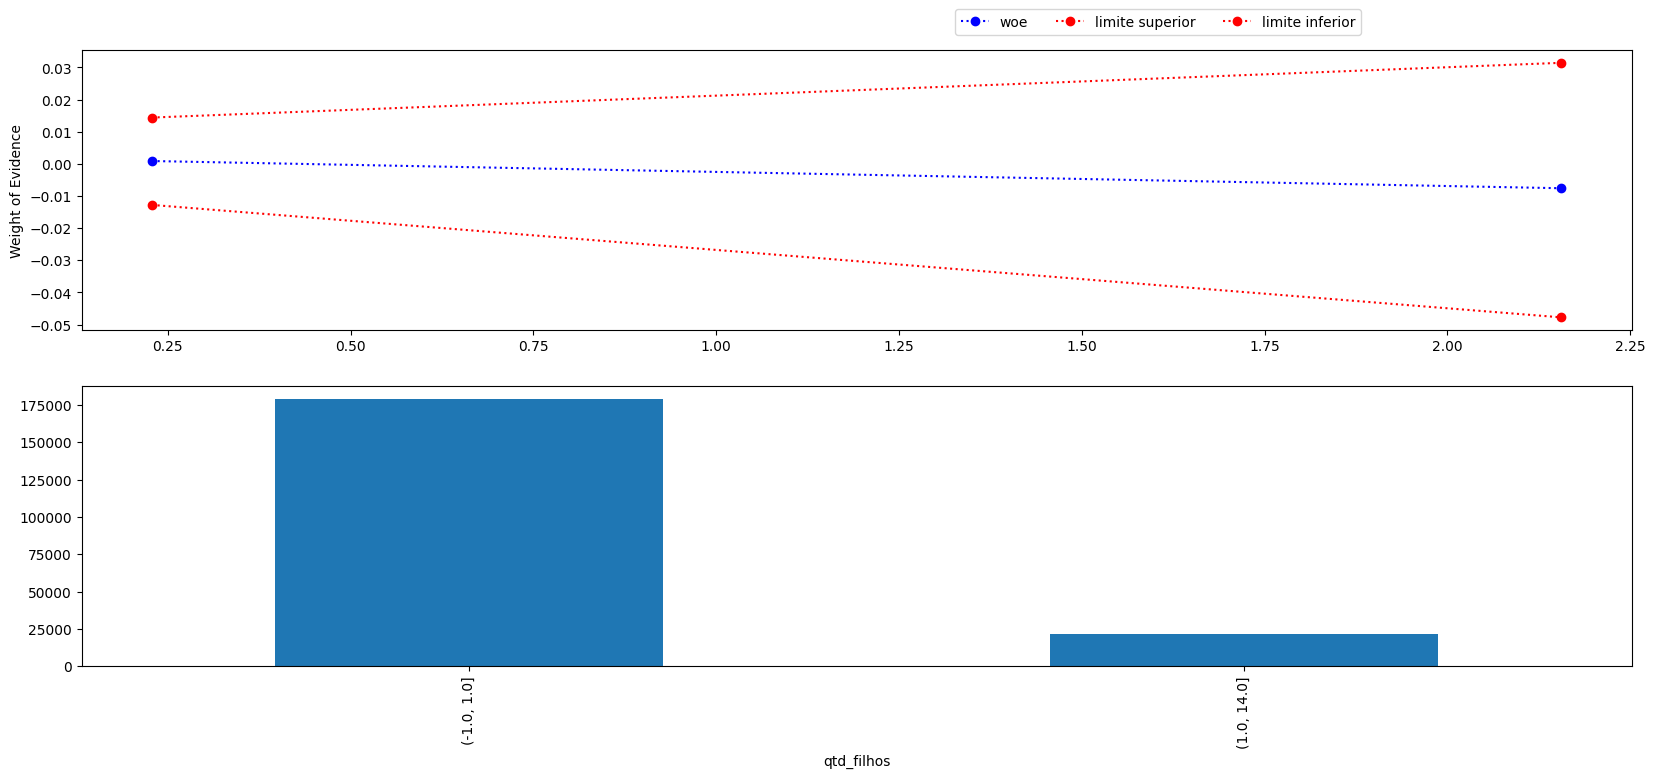

In [54]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


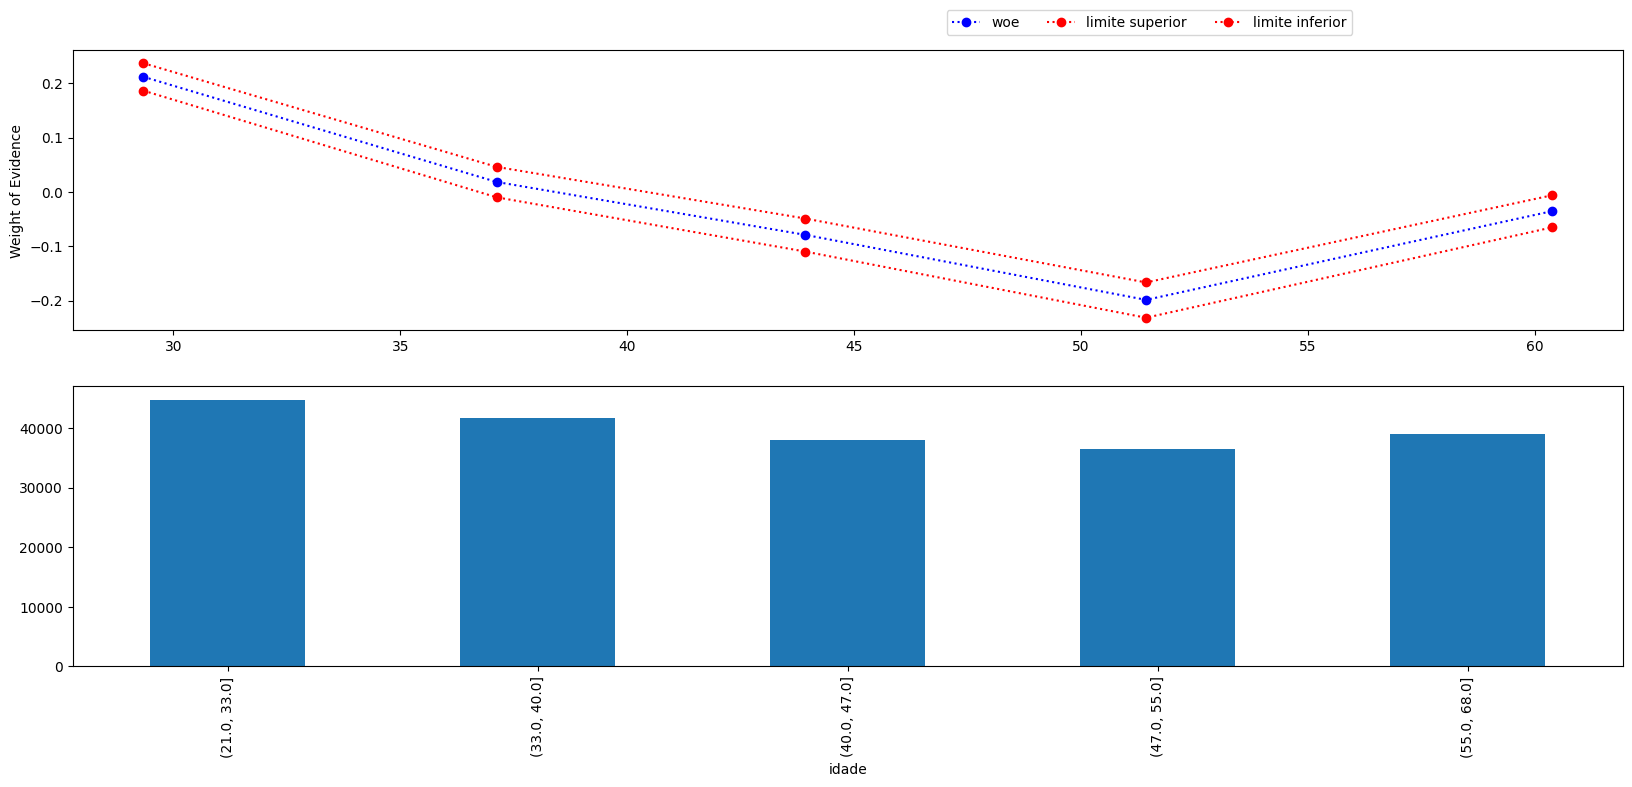

In [55]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


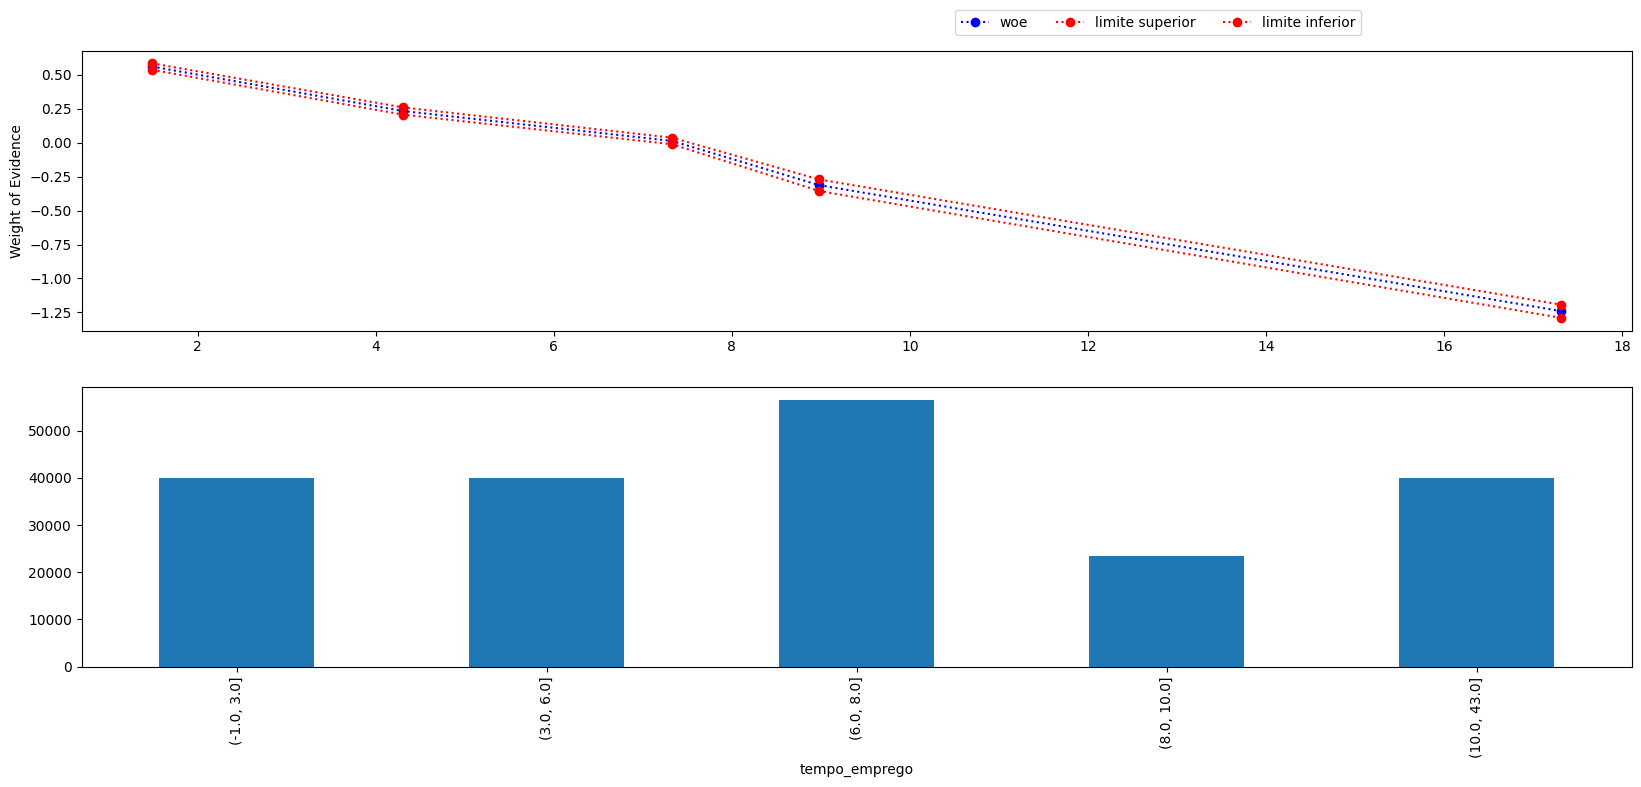

In [56]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


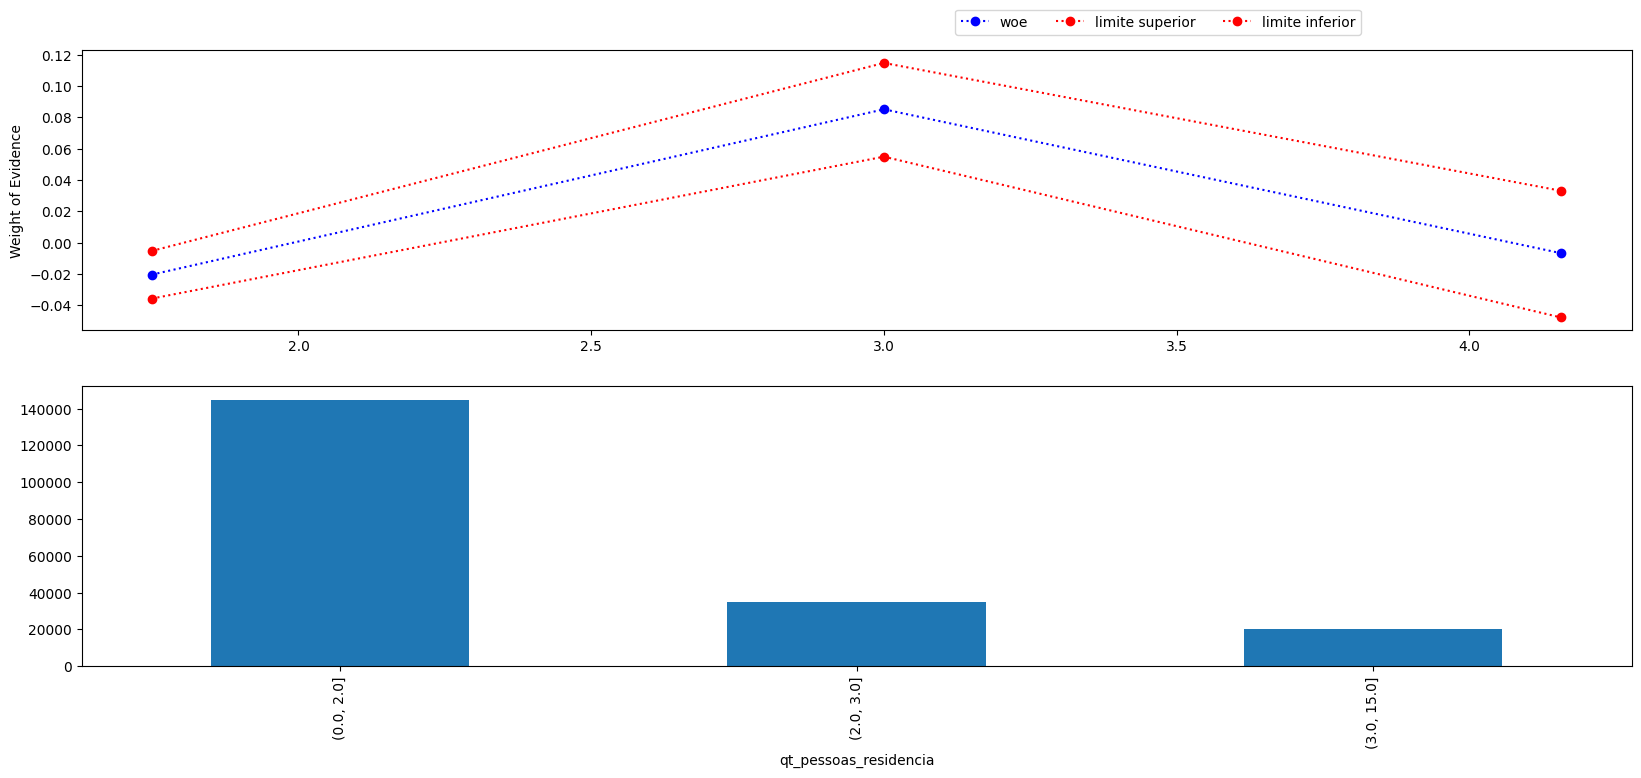

In [57]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


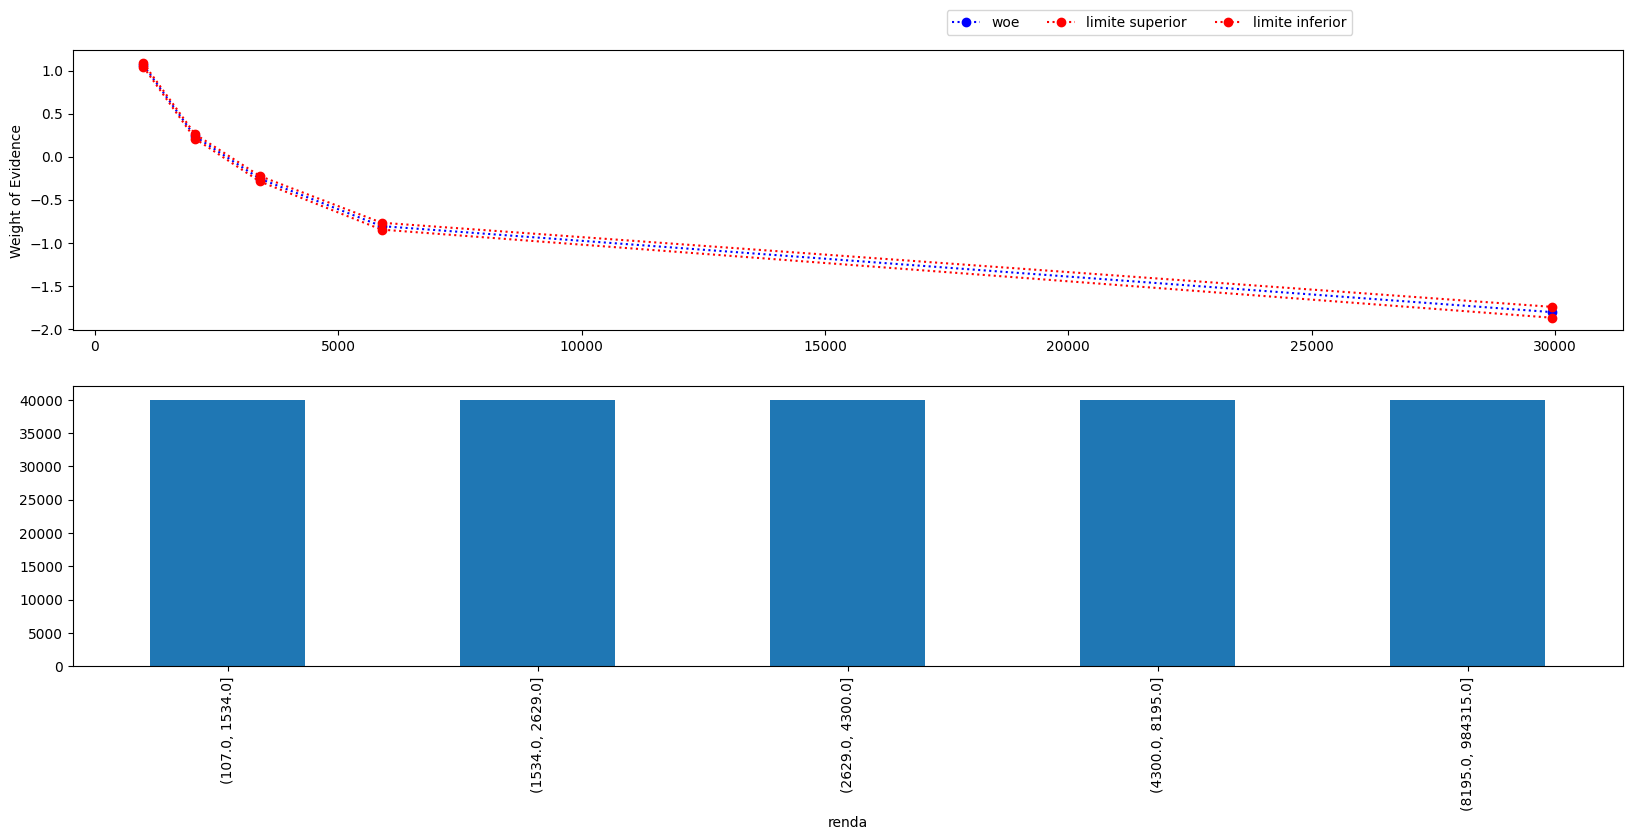

In [58]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_22608\1510209028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


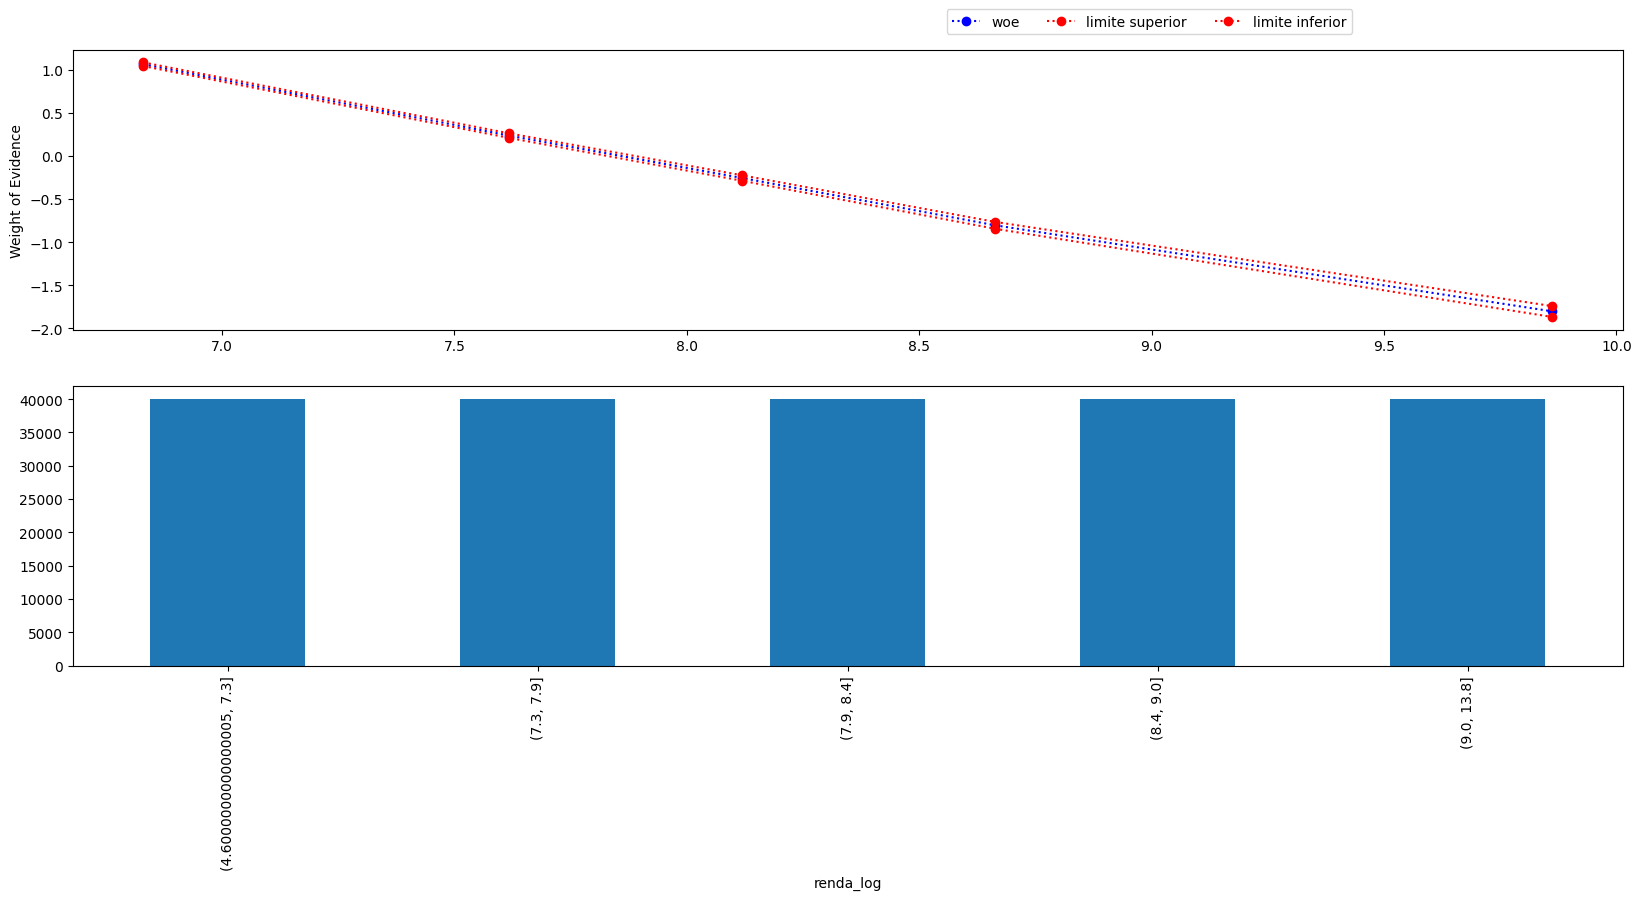

In [59]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

In [17]:
metadados_train = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados_train['nmissing'] = df_train.isna().sum()
metadados_train['valores_unicos'] = df_train.nunique()
metadados_train['papel'] = 'covariavel'
metadados_train.loc['mau','papel'] = 'resposta'
metadados_train

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,11,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


In [18]:
metadados_valid = pd.DataFrame(df_valid.dtypes, columns=['dtype'])
metadados_valid['nmissing'] = df_valid.isna().sum()
metadados_valid['valores_unicos'] = df_valid.nunique()
metadados_valid['papel'] = 'covariavel'
metadados_valid.loc['mau','papel'] = 'resposta'
metadados_valid

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,4,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.